# Batch analysis of cosmic rays using Drift Tubes detectors
Group 8: Lorenzo Borella, Mattia Ceravolo, Marco Giunta, Samuele Pio Lipani

In [1]:
import numpy as np 
import pandas as pd 
import os
import dask.dataframe as dd 
import dask.bag as db 
from dask.distributed import Client
import matplotlib.pyplot as plt 
from numba import njit
from itertools import product 
from matplotlib.patches import Rectangle
import plotly.express as px

### A technical note
If we use a fraction of the available data memory consumption isn't really an issue; indeed with a small enough fraction of the dataset everything fits comfortably inside memory, and dask could in principle be replaced entirely with pandas. Since certain operations are more efficient with pandas we decided to add the possibility of replacing some dask-based operations with pandas-based equivalent ones; this was very useful to accelerate testing, since we initially experimented only on a limited fraction of the available files.        
On the other hand this "contamination" isn't "sustainable", since it limits the notebook's scalability with dataset size - hence we want to be able to switch to a pure dask based pipeline, too. To control this we used a `pure_dask` global boolean variable, which is visible below and in multiple occasions decides whether a certain operation is carried out in pandas or dask.

In [2]:
pure_dask = True
nhead = 20
show_head = True

client = Client('localhost:8786')
client

<Client: 'tcp://10.67.22.196:8786' processes=3 threads=12, memory=22.91 GiB>

# Preprocessing
We preprocess our dataset in two steps:
- first we dump the data in a `dask.bag` and use a custom function to decode from binary. This function also allows us to give a rectangular shape to the dataset, which is needed in order to convert to `dask.dataframe`;
- then we filter the obtained dataframe by discarding events which are probably noise using a variety of criteria to be explained below.
     
We choose to convert the bag to dataframe as soon as it has a rectangular shape, because bags really excel at non-rectangular data (e.g. data where some fields have variable length); indeed when the same operation can be performed with both formats dataframes are usually more efficient (a good example of this is given by [bag.groupby vs dataframe.groupby](https://tutorial.dask.org/02_bag.html)). We'll mention below when an equivalent bag-based operation can be performed and why we chose the dataframe counterpart.

In [3]:
# bag creation
# the recommended way to proceed here (see for example https://docs.dask.org/en/latest/bag-api.html#dask.bag.from_sequence) is to:
# - create a list of file names/paths;
# - load it into a dask bag using from_sequence;
# - applying a function which turns a file path into data to the bag of filenames using map, obtaining the actually interesting bag.

files = ['./data/' + s for s in os.listdir("./data")][:20]

b = db.from_sequence(files)

## Decoding from binary 
Now we need to supply the function to `map` to our bag; this function must be able to dump and decode the content of our dataset, which means we need to describe how data is encoded.              
Each provided file is a binary sequence of 64 bit words with the following meaning:
\begin{equation}
  \underbrace{010}_{\text{head (3b)}} \underbrace{000}_{\text{fpga (3b)}} \underbrace{111100100}_{\text{chan (9b)}} \underbrace{00011100001011010011110010111001}_{\text{orbit (32b)}} \underbrace{000001011101}_{\text{bx (12b)}} \underbrace{10101}_{\text{tdc (5b)}}
\end{equation}
We can load each 64 bit word in an array using numpy's `fromfile` function, specifying the underlying format is unsigned 64 bit; then we can extract each part using the bitwise `&` and `>>` operators as follows.        
Imagine we need to extract the `head` part, which is 3 bit long and has 61 bits to its right; to get it we can then compute the logical and with the number 111 followed by 61 zeros, and shift by 61 places. Similar reasoning applies to each field; the numbers we need to use in conjuction with each `&` and `>>` can be easily computed as follows.

In [73]:
field_lengths = np.array([5, 12, 32, 9, 3, 3])
print('length of each field in bits:', field_lengths)
print('tot. number of bits per word:', field_lengths.sum())

bit_shift = np.array([0, *list(field_lengths.cumsum()[:-1])])
bit_and_bin = ['1'*fl + '0'*bb for fl, bb in zip(field_lengths, bit_shift)][:-1] + ['0']
bit_and_dec = [int(i, 2) for i in bit_and_bin]

print('number of places to shift for each field (>> operator):', bit_shift)
print('numbers with which to compute the bitwise and (bin.):', bit_and_bin) # for "head" there's no need to compute the and, we can simply shift by 61 places
print('numbers with which to compute the bitwise and (dec.):', bit_and_dec)

length of each field in bits: [ 5 12 32  9  3  3]
tot. number of bits per word: 64
number of places to shift for each field (>> operator): [ 0  5 17 49 58 61]
numbers with which to compute the bitwise and (bin.): ['11111', '11111111111100000', '1111111111111111111111111111111100000000000000000', '1111111110000000000000000000000000000000000000000000000000', '1110000000000000000000000000000000000000000000000000000000000', '0']
numbers with which to compute the bitwise and (dec.): [31, 131040, 562949953290240, 287667426198290432, 2017612633061982208, 0]


In [4]:
def load_from_file(fp) :
    m = np.fromfile(fp, dtype = '<u8')
    mat = np.zeros((m.shape[0], 6), dtype = "u4") 
    mat[:,0] = m & 31 # tdc, bits 0-4 (5 bits)
    mat[:,1] = (m & 131040) >> 5 # bx, bits 5-16 (12 bits)
    mat[:,2] = (m & 562949953290240) >> 17 # orbit, bits 17-48 (32 bits)
    mat[:,3] = (m & 287667426198290432) >> 49 # chan, bits 49-57 (9 bits)
    mat[:,4] = (m & 2017612633061982208) >> 58 # fpga 61-63 (3 bits)
    mat[:,5] = m >> 61

    return mat

### Conversion to dataframe
Now we can properly load our dataset. Notice that since `load_from_file` returns a 6-columns array the result of mapping it to our bag can be readily cast to dataframe (as long as we specify the name and dtype of each field).

In [5]:
base_dtypes = {'tdc':'u1', 'bx':'u2', 'orbit':'u4', 'chan':'u2', 'fpga':'u1', 'head':'u1'} # most field fit inside 8 bits. Also notice that each field cannot be negative

df = b.map(load_from_file).flatten().to_dataframe(meta = base_dtypes)

## Filter 0: `head == 2`
We can now start to remove noisy/useless rows from our dataset. The first filter is to remove hits with `head` different from 2, as these represent ancillary data irrelevant for this analysis.       
Notice that this filter could have been implemented using e.g. `bag.filter()` + a lambda function which returns `b[head] == 2`, but this is much slower than writing out this filter in a vectorized fashion as done below; this is why we switched to dataframe immediately instead of waiting (which is useless, since we will eventually *have* to convert to dataframe).

In [6]:
df = df[df['head'] == 2] # this is faster and more readable than a bag.filter() based alternative

In [7]:
if show_head :
    display(df.head(nhead))

,tdc,bx,orbit,chan,fpga,head
4,2,2922,3387200947,75,0,2
5,29,2227,3387200955,105,0,2
6,7,2234,3387200955,107,0,2
7,29,476,3387200973,126,0,2
8,12,1797,3387200955,55,1,2
9,28,2165,3387200956,36,1,2
10,14,249,3387200970,51,1,2
11,28,475,3387200973,90,1,2
20,16,485,3387200973,124,0,2
21,5,480,3387200973,127,0,2


## Filter 1: limiting min. and max. number of hits per orbit + two fundamental assumptions
### min. number of hits
As we know one of the main goals of this project is to ultimately perform two kinds of linear fits: a local, chamber-based one and a global, event based one. A linear fit with just two points is meaningless; this means we can only deal with events that have:
- at least 3 hits per chamber, in order to grant meaning to the local fit;
- at least 2 active chambers, in order to make a global fit possible (otherwise we can only have a local one)

We'll explicitly check that filtered events have more than one active chamber; for now it suffices to say that the previous two bullet points imply we need to discard events with less than 6 hits. Also notice that we haven't yet separated the hits associated to the trigger activation from those caused by actual muons, so we actually need to set $n_{\text{min}} = 7$.

Before proceeding with stating what to set $n_{\text{max}}$ equal to let's discuss a couple of funding assumptions.
### Orbits and events, almost vertical trajectories
This data analysis pipeline was set up according to two fundamental principles, which we report here since they fix $n_{\text{max}}$.    
- *Orbits = events*. We operate under the assumptions that a muon passage is so rare that it's almost impossible to find orbits with more than one muon. Of course our dataset may contain legitimately physical events with multiple muons, but a) if there are such events they make up a negligible fraction of the total, and b) in order to be legit they need to have a huge number of active cells, which means that with our value of $n_{\text{max}}$ they won't pass through our filters. Dropping them is not an issue because as just said events like these are very rare, and since events with too many hits are hard to handle (cfr assignment hints) we'd rather drop a few more "true" events than deal with the difficulties arising from trying to deal with these.   
Due to this point we operate on the assumption that *"grouping by event" and "grouping by orbit" are the same thing.* 
- *"Good events are not horizontal"*. By exploring the dataset we noticed that the "cleanest" events were almost vertical, and never beyond 45-50 degrees wrt the vertical. In particular it was hard finding good events with almost horizontal trajectories; even if there were many good horizontal events these would also need to activate many cells, thus requiring us to drop the assumption of discarding orbits with too many hits (which again is impractical). One could design a more general pipeline, capable of "accepting" even rare events of this kind; we are happy with the compromise of building a simpler but easier to write and well-functioning pipeline, which only deals with events of the "almost vertical" kind.

### max. number of hits
The last bullet point made above means that we can set $n_{\text{max}} = 16$; indeed if one only cares about events with not too tilted trajectories then $n_{\text{max}} = 16$ is the most natural choice for the following reason.                 
Almost vertical trajectories cross any given chamber layer only once, and ideally cross every layer and chamber; this implies that ideally every event of this kind triggers 4 cells in 4 chambers i.e. 16 hits. In reality, of course, a cell may fail to activate, so we can only assume $n\leq 16$ - but this is fine since right now we only want a sensible upper bound on the number of hits per orbit.        
Once again since physical orbits need to have a trigger activation we actually set $n_{\text{max}} = 17$, to accomodate for the scintillator.

### An experimental verification of $n_{\text{max}} = 16$?
On a separate session we re-executed the notebook with the upper cap on $n$ removed, in order to see whether our argument for 16 made sense. Indeed we found that no "clean" orbit had more than 16 hits (scintillator removed), but this is not necessarily significant. Indeed as said above we operated under the assumption that good events are almost vertical, and consequently some of our filters reflected this bias - hence in order to have a completely unbiased "experimental" verification of what $n_{\text{max}}$ is one would have to design a more general pipeline, which is obviously too impractical.       
Once again we are happy with the compromise of designing an algorithm inside which everything is consistent - even if it means potentially sacrifying an (admittedly small) fraction of the good events in our data.    
See the end of the notebook for an histogram of the number of hits/orbit in the filtered dataset.

In [8]:
# dropping orbits with a number of hits that doesn't satisfy 7 <= n <= 17 i.e. 6 <= n-1 <= 16 (scintillator)
if not pure_dask :
    cnt = df.orbit.value_counts().compute()
    cnt = cnt[(cnt > 6) & (cnt < 18)]
    df1 = df[df['orbit'].isin(cnt.index)] 
else :
    def nhits_bounds(group) :
        if group.size//6 > 6 and group.size//6 < 18 : # dask.groubpy.size yields the number of rows*columns, instead of pandas.groupby.size which only returns the number of rows; hence we divide by the n. of cols
            return group 
        else : 
            return None 
    df1 = df.groupby('orbit').apply(nhits_bounds, meta = base_dtypes).dropna().reset_index(drop = True)

In [9]:
if show_head :
    display(df1.head(nhead))

,tdc,bx,orbit,chan,fpga,head
7,29,476,3387200973,126,0,2
11,28,475,3387200973,90,1,2
20,16,485,3387200973,124,0,2
21,5,480,3387200973,127,0,2
24,18,481,3387200973,42,1,2
25,6,480,3387200973,91,1,2
26,20,482,3387200973,45,1,2
27,21,489,3387200973,88,1,2
40,1,491,3387200973,138,1,2
41,19,485,3387200973,43,1,2


## Filter 2: ensuring scintillator activation
As we know in order to reconstruct the position of the particle in each active cell (up to left-right ambiguity) we need to compute the *time pedestal* $t_0$, which (up to a correction) is simply the time associated with the activation of the scintillator caused by the arrival of the particle in the detector. This means that orbits with no active scintillator are either noise or events where the scintillator failed to trigger for some reason; in either case these events cannot be dealt with, since we're missing $t_0$ - and hence need to be discarded.

In [10]:
# removing orbits with no scintillator activation to ensure t0 can always be computed
if not pure_dask :
    orbits_with_sc = df1[(df1['fpga'] == 1) & (df1['chan'] == 128)].orbit.compute()
    df2 = df1[df1['orbit'].isin(orbits_with_sc)]
else :
    def scintillator(group) :
        if ((group['fpga'] == 1) & (group['chan'] == 128)).any() :
            return group
        else:
            return None
    df2 = df1.groupby('orbit').apply(scintillator, meta = base_dtypes).dropna()#.astype(base_dtypes)

In [11]:
if show_head :
    display(df2.head(nhead))

,tdc,bx,orbit,chan,fpga,head
6683,27,878,1118948,91,1,2
6687,8,882,1118948,107,0,2
6688,18,881,1118948,47,1,2
6689,12,884,1118948,88,1,2
6690,7,881,1118948,128,1,2
6691,14,881,1118948,44,1,2
6692,17,883,1118948,90,1,2
6693,1,891,1118948,138,1,2
6694,5,887,1118948,46,1,2
6695,12,889,1118948,89,1,2


## Filter 3: ensuring a well defined $t_0$ by discarding orbits with multiple scintillator activations
Not only are there orbits with no scintillator activation, but some have *multiple* ones. This means that $t_0$ is ill-defined for these events, since either multiple muons arrived (which we have no simple way to distinguish in terms of the hits they caused) or it's just noise. In either case events like these need to be dropped, since otherwise $t_0$ would be ambiguous.

In [12]:
# rimuovo le orbite con più scintillatori
if not pure_dask :
    v1, v2 = np.unique((df2['orbit'][(df2.chan == 128) & (df2.fpga == 1)]).compute(), return_counts = True)
    df3 = df2[df2.orbit.isin(v1[v2 < 2])]
else :
    def multiple_sc(group) :
        if np.count_nonzero((group['chan'] == 128) & (group['fpga'] == 1)) < 2 :
            return group 
        else :
            return None
    df3 = df2.groupby('orbit').apply(multiple_sc, meta = base_dtypes).dropna()#.astype(base_dtypes)

In [13]:
if show_head :
    display(df3.head(nhead))

,tdc,bx,orbit,chan,fpga,head
6683,27,878,1118948,91,1,2
6687,8,882,1118948,107,0,2
6688,18,881,1118948,47,1,2
6689,12,884,1118948,88,1,2
6690,7,881,1118948,128,1,2
6691,14,881,1118948,44,1,2
6692,17,883,1118948,90,1,2
6693,1,891,1118948,138,1,2
6694,5,887,1118948,46,1,2
6695,12,889,1118948,89,1,2


## `chamber` and `layer` assignment
We now unpack the information contained in each hit channel to place each of them inside the appropriate cell.                  
To compute the chamber it suffices to use the following mapping (cfr problem assignment):
- chamber 0: fpga = 0, channel in $[0, 63]$
- chamber 1: fpga = 0, channel in $[64, 127]$
- chamber 2: fpga = 1, channel in $[0, 63]$
- chamber 3: fpga = 1, channel in $[64, 127]$
           
To compute the layer let's temporarily assume we count from 0. According to the figure at page 17 of the project assignment we notice that every cell in layer 1 has a channel whose modulo division by 4 equals 1; the same holds for layer 2. Layer 0, instead, has 3 as the result of this operation, and similarly layer 3 results in 0 (since those are all multiples of 4); this means that we can set `layer = channel % 4`, but we then need to switch 0 with 3 and vice versa.             
Now notice that the project assignment actually assumes layer numbering starts from 1; due to this we increment the aforementioned results by 1.

In [14]:
# chamber and layer assignment

df3['chamber'] = 23 # placeholder value

masks = [(df3["fpga"] == 0) & (df3["chan"] < 64),
         (df3["fpga"] == 0) & (df3["chan"] > 63),
         (df3["fpga"] == 1) & (df3["chan"] < 64),
         (df3["fpga"] == 1) & (df3["chan"] > 63)]

for i, mask in enumerate(masks):
    df3["chamber"] = df3["chamber"].mask(mask, i)


df3['layer'] = df3["chan"] % 4
df3['layer'] = df3['layer'].replace({0:3, 3:0}) # 2:2, 1:1

df3['layer'] += 1

dtypes = {**base_dtypes, 'chamber':'u1', 'layer':'i1'}
df3 = df3.astype(dtypes)

In [15]:
#display(df3)
if show_head :
    display(df3.head(nhead))

,tdc,bx,orbit,chan,fpga,head,chamber,layer
6683,27,878,1118948,91,1,2,3,1
6687,8,882,1118948,107,0,2,1,1
6688,18,881,1118948,47,1,2,2,1
6689,12,884,1118948,88,1,2,3,4
6690,7,881,1118948,128,1,2,3,4
6691,14,881,1118948,44,1,2,2,4
6692,17,883,1118948,90,1,2,3,3
6693,1,891,1118948,138,1,2,3,3
6694,5,887,1118948,46,1,2,2,3
6695,12,889,1118948,89,1,2,3,2


## $t$, $t_0$ and $\Delta t$ computation
We now compute the two values needed to obtain $\Delta t$, which up to a factor of $v_d$ is needed to obtain the (still ambiguous) horizontal position of each hit.      
- *$t$ computation:* as we know the physical time in nanoseconds can be obtained using the formula:
\begin{equation}
  t = 25 \left(3564 \cdot \text{orbit} + \text{bx} + \frac{1}{30}\text{tdc} \right)
\end{equation}
Notice, though, that we only really care about *differences* of times of hits belonging to the same event i.e. to the same orbit - hence we don't *need* to consider the first term in the `t` column computation. Actually we observe that it would be *detrimental* to add orbit to $t$: indeed even without the large 25*3564 factor in front orbit is a huge number wrt bx and tdc, hence it would cause a loss of information - and every computed $\Delta t$ would be basically meaningless due to the limited machine precision.      
Therefore we compute the `t` column using:
\begin{equation}
  t = 25 \left(\text{bx} + \frac{1}{30}\text{tdc} \right)
\end{equation}
- *$t_0$ computation:* the last filters ensure that every orbit contains one and only one scintillator hit; to compute $t_0$ *for the whole orbit*, then, it suffices to copy the scintillator's `t` and assign it to the `t0` column of the whole orbit.
- *$\Delta t$ computation:* finally we compute $\Delta t$ as $t - t_0$ plus a chamber dependent correction term (cfr project assignment): 95 ns + $h$ where $h$ is -1.1 for chamber 0, 6.4 for chamber 1, 0.5 for chamber 2, -2.6 for chamber 3.

In [16]:
# t and t0 computation
df3['t'] = 25*df3['bx'] + 25*df3['tdc']/30

def time_pedestal(group):
    length = group.shape[0]
    scint = group[group["chan"] == 128].t.values
    group = group.assign(t0 = np.repeat(a = scint, repeats = length))
    return group

dtypes = {**dtypes, 't':'f8', 't0':'f8'}
df3 = df3.groupby('orbit').apply(time_pedestal, meta = dtypes).reset_index(drop=True)

time_offset = np.array([-1.1, 6.4, 0.5, -2.6])

# offset: by chamber
df3['dt'] = df3['t'] - df3['t0'] + 95 # correction term added below

for i, to in enumerate(time_offset):
    df3['dt'] = df3['dt'].mask(df3['chamber'] == i, other = df3['dt'] + to) 

dtypes['dt'] = 'f8'

In [17]:
if show_head :
    display(df3.head(nhead))

,tdc,bx,orbit,chan,fpga,head,chamber,layer,t,t0,dt
0,27,878,1118948,91,1,2,3,1,21955.433333,22030.833333,17.000000
1,8,882,1118948,107,0,2,1,1,22056.666667,22030.833333,127.233333
2,18,881,1118948,47,1,2,2,1,22031.466667,22030.833333,96.133333
3,12,884,1118948,88,1,2,3,4,22101.466667,22030.833333,163.033333
4,7,881,1118948,128,1,2,3,4,22030.833333,22030.833333,92.400000
5,14,881,1118948,44,1,2,2,4,22028.133333,22030.833333,92.800000
6,17,883,1118948,90,1,2,3,3,22080.633333,22030.833333,142.200000
7,1,891,1118948,138,1,2,3,3,22275.833333,22030.833333,337.400000
8,5,887,1118948,46,1,2,2,3,22179.166667,22030.833333,243.833333
9,12,889,1118948,89,1,2,3,2,22226.466667,22030.833333,288.033333


## Filter 4: removing unphysical drift times
As we know when a muon goes through a cell it generates charges which move towards the center of the cell; clearly since these ions are generated *inside* the cell they cannot be further from the cell center by more than half of the cell length (which happens in the extreme case where charges are created on the edge of the cell). This means that *no physical $\Delta t$ can be greater than $T_{\text{max}} = (L/2)/v_d$*; any hit with larger drift times is necessarily noise.      
Notice that these unphysical hits are easily spotted, since according to the graphical representation to be seen later they would be outside the detector..!              

We also observe a small fraction of hits whose drift time is *negative*. This doesn't mean these events aren't physical, since maybe there was simply an unusually large delay in the signal trasmission - but since a) these events are a negligible fraction of the total, and b) we have no obvious way to "save" these events we simply discard rows with $\Delta t < 0$.

In [18]:
# dt > Tmax and dt < 0 removal
T = 21/53.8e-3 # L = 42 mm, v_d = 53.8e.3 mm/ns
df4 = df3[(df3.dt < T) & (df3.dt > 0)]

In [19]:
if show_head :
    display(df4.head(nhead))

,tdc,bx,orbit,chan,fpga,head,chamber,layer,t,t0,dt
0,27,878,1118948,91,1,2,3,1,21955.433333,22030.833333,17.000000
1,8,882,1118948,107,0,2,1,1,22056.666667,22030.833333,127.233333
2,18,881,1118948,47,1,2,2,1,22031.466667,22030.833333,96.133333
3,12,884,1118948,88,1,2,3,4,22101.466667,22030.833333,163.033333
4,7,881,1118948,128,1,2,3,4,22030.833333,22030.833333,92.400000
5,14,881,1118948,44,1,2,2,4,22028.133333,22030.833333,92.800000
6,17,883,1118948,90,1,2,3,3,22080.633333,22030.833333,142.200000
7,1,891,1118948,138,1,2,3,3,22275.833333,22030.833333,337.400000
8,5,887,1118948,46,1,2,2,3,22179.166667,22030.833333,243.833333
9,12,889,1118948,89,1,2,3,2,22226.466667,22030.833333,288.033333


## Filter 5: scintillators removal
Once we computed $t_0$ hits associated with scintillator activations are no longer useful, and can be dropped to further reduce the dataset size. We also remove them to ensure no unphysical points appear in the graphical representation we'll show later.         
Notice that even though scintillators have channel = 128 we actually remove hits with channel $\geq$ 128, because some hits have even larger channel values; this is probably just some ancillary data, similar to head $\neq$ 2 - hence irrelevant for the present analysis.

In [20]:
# we remove scintillators + spurious channels
df5 = df4[df4['chan'] < 128]

In [21]:
if show_head :
    display(df5.head(nhead))

,tdc,bx,orbit,chan,fpga,head,chamber,layer,t,t0,dt
0,27,878,1118948,91,1,2,3,1,21955.433333,22030.833333,17.000000
1,8,882,1118948,107,0,2,1,1,22056.666667,22030.833333,127.233333
2,18,881,1118948,47,1,2,2,1,22031.466667,22030.833333,96.133333
3,12,884,1118948,88,1,2,3,4,22101.466667,22030.833333,163.033333
5,14,881,1118948,44,1,2,2,4,22028.133333,22030.833333,92.800000
6,17,883,1118948,90,1,2,3,3,22080.633333,22030.833333,142.200000
8,5,887,1118948,46,1,2,2,3,22179.166667,22030.833333,243.833333
9,12,889,1118948,89,1,2,3,2,22226.466667,22030.833333,288.033333
10,20,890,1118948,105,0,2,1,2,22258.133333,22030.833333,328.700000
11,13,891,1118948,108,0,2,1,4,22277.300000,22030.833333,347.866667


## Filter 6: discarding events with less than 3 active layers
In order to solve the left right ambiguity we'll later perform a linear fit for each chamber in each event; as mentioned above fits of this kind lose meaning if done with less than 3 points. Before we simply ensured that each *orbit* contains a minimum number of hits, but without requiring that these be distributed so that each *(orbit, chamber)* pair contain at least 3 hits; we now want to filter by this more restrictive criterion.          
Actually we want something even stronger: in order to start implementing the *"almost vertical" bias* we only keep (orbit, chamber) pairs that *not only contain at least 3 hits*, but that contain *at least 3 hits in at least 3 different layers*. Why this is consistent with the "almost vertical" assumption is easy to see if one pictures an ideal event with an almost vertical trajectory.        
To sum up: we're stating that in order to be relevant events need to have *at least 3 hits per chamber*, placed in *at least 3 different layers*. Since the second request implies the first it suffices to implement only the last one.            
Notice that since we removed scintillator activations we no longer need to account for the +1 correction term in our inequalities.

In [22]:
# we drop local events (group by orbit and chamber) with less than 3 active layers
def min_n_active_layers(group): 
    if group['layer'].nunique() > 2 : 
        return group
    else :
        return None

df6 = df5.groupby(['orbit', 'chamber']).apply(min_n_active_layers, meta = dtypes).dropna().reset_index(drop = True) 

In [23]:
if show_head :
    display(df6.head(nhead))

,tdc,bx,orbit,chan,fpga,head,chamber,layer,t,t0,dt
0,25,3234,1163664,110,0,2,1,3,15317.766667,15397.333333,21.833333
1,18,3237,1163664,111,0,2,1,1,15395.466667,15397.333333,99.533333
2,3,3246,1163664,108,0,2,1,4,15616.500000,15397.333333,320.566667
3,1,3248,1163664,113,0,2,1,2,15664.833333,15397.333333,368.900000
4,21,2663,1175583,108,0,2,1,4,1039.433333,1119.000000,21.833333
5,4,2668,1175583,111,0,2,1,1,1167.333333,1119.000000,149.733333
6,2,2670,1175583,109,0,2,1,2,1215.666667,1119.000000,198.066667
7,2,2674,1175583,110,0,2,1,3,1315.666667,1119.000000,298.066667
8,7,2071,1248672,49,1,2,2,2,51780.833333,51807.500000,68.833333
9,14,2072,1248672,48,1,2,2,4,51803.133333,51807.500000,91.133333


## Filter 7: dropping events with hits on the same layer
We reinforce the "almost vertical" bias by removing (orbit, chamber) pairs that contain multiple hits on the same layers. This isn't simply a way to remove "uninteresting" horizontal trajectories (which as already said make up a small fraction of the satisfyingly "cleanable" events) as much as it is a means to remove noisy events. Indeed it often happens that potentially good events are ruined by a spurious cell activation very far from the "interesting" region due to random noise; these events clearly need to be discarded, so we start by asking no two hits per orbit/chamber share the same layer value - later we'll ask something even more specific and consistent with the "almost vertical" biased assumption.

In [24]:
# we remove chambers with multiple hits in the same layer
def same_layer(group) :
    if group['layer'].nunique() == len(group) :
        return group
    else :
        return None 

df7 = df6.groupby(['orbit', 'chamber']).apply(same_layer, meta = dtypes).dropna().reset_index(drop = True)

In [25]:
if show_head :
    display(df7.head(nhead))

,tdc,bx,orbit,chan,fpga,head,chamber,layer,t,t0,dt
0,25,3234,1163664,110,0,2,1,3,15317.766667,15397.333333,21.833333
1,18,3237,1163664,111,0,2,1,1,15395.466667,15397.333333,99.533333
2,3,3246,1163664,108,0,2,1,4,15616.500000,15397.333333,320.566667
3,1,3248,1163664,113,0,2,1,2,15664.833333,15397.333333,368.900000
4,21,2663,1175583,108,0,2,1,4,1039.433333,1119.000000,21.833333
5,4,2668,1175583,111,0,2,1,1,1167.333333,1119.000000,149.733333
6,2,2670,1175583,109,0,2,1,2,1215.666667,1119.000000,198.066667
7,2,2674,1175583,110,0,2,1,3,1315.666667,1119.000000,298.066667
8,7,2071,1248672,49,1,2,2,2,51780.833333,51807.500000,68.833333
9,14,2072,1248672,48,1,2,2,4,51803.133333,51807.500000,91.133333


## "Filter" 8:  `column` and `center` computation
### subtracting 64 from `channel`
Each chamber houses 64 cells, which is why `channel` is either in $[0, 63]$ or in $[64, 127]$; whether it's the former or the latter interval is simply a way to distinguish between different chambers; now that we computed the `chamber` column this distinction is no longer needed, and we can map $[64, 127]$ to $[0, 63]$ to more easily compute the `column` and `center` columns.

### column
In order to apply the next filter and to compute the (still ambiguous) position of each hit inside the detector we first compute in which column of the detector geometry the hit is to be placed; this is a value between 1 and 16, which is lowest on the left and increases towards the right according to the convention set by us.              
By looking at the detector representation we easily notice that for layer 1 the `column` value simply equals `(channel + 1)/4`; similarly for layer 4 one has `column = (channel + 4)/4`. Layer 2 and 3, instead, have `column = (channel + 3)/4` and `column = (channel + 2)/4` respectively; this means that we can use the formula `column = (channel + layer)/4` for layers 1 and 4, and `column = (channel + 3)/4`, `column = (channel + 2)/4` for layers 2 and 3 respectively.

### center
Once we know the column value of each hit (a unitless number) we can compute the position in mm wrt the leftmost part of the detector of the center of each cell; this is useful because the $x$ physical position  of each hit is (up to ambiguity) this value $\pm v_d \Delta t$.                                       
We adopt the convention of measuring `center` in units of $L/2$, where $L = 42 \ \text{mm}$ is the length of a single cell; we'll convert to mm later. With this convention it is straightforward to compute `center` from `column`: indeed for layers 1 and 3 `center` is simply `column` times 2, whereas for layers 2 and 4 it's the same value -1 due to the detector geometry.

In [26]:
# column, center computation
df8 = df7.copy()
df8['chan'] = df8['chan'].mask((df8['chan'] > 63), other = df8['chan'] - 64)

df8["column"] = (df8['chan'] + df8["layer"]) / 4

df8['column'] = df8['column'].mask(df8['layer'] == 2, other = (3 + df8['chan'])/4)
df8['column'] = df8['column'].mask(df8['layer'] == 3, other = (2 + df8['chan'])/4)


df8['center'] = df8['column']*2
df8['center'] = df8['center'].mask(df8['layer'] == 2, other = df8['center'] - 1)
df8['center'] = df8['center'].mask(df8['layer'] == 4, other = df8['center'] - 1)

dtypes = {**dtypes, 'column':'u1', 'center':'i2'} # we cast center to i2 instead of u1 to prevent overflows etc. later; see below
df8 = df8.astype(dtypes)

In [27]:
if show_head :
    display(df8.head(nhead))

,tdc,bx,orbit,chan,fpga,head,chamber,layer,t,t0,dt,column,center
0,25,3234,1163664,46,0,2,1,3,15317.766667,15397.333333,21.833333,12,24
1,18,3237,1163664,47,0,2,1,1,15395.466667,15397.333333,99.533333,12,24
2,3,3246,1163664,44,0,2,1,4,15616.500000,15397.333333,320.566667,12,23
3,1,3248,1163664,49,0,2,1,2,15664.833333,15397.333333,368.900000,13,25
4,21,2663,1175583,44,0,2,1,4,1039.433333,1119.000000,21.833333,12,23
5,4,2668,1175583,47,0,2,1,1,1167.333333,1119.000000,149.733333,12,24
6,2,2670,1175583,45,0,2,1,2,1215.666667,1119.000000,198.066667,12,23
7,2,2674,1175583,46,0,2,1,3,1315.666667,1119.000000,298.066667,12,24
8,7,2071,1248672,49,1,2,2,2,51780.833333,51807.500000,68.833333,13,25
9,14,2072,1248672,48,1,2,2,4,51803.133333,51807.500000,91.133333,13,25


## Filter 9: "horizontal closeness", i.e. no "jumps" allowed
A significant fraction of events is such that even though there is only one hit per layer one of them is really far away from the others. Events like these are too noisy to make it possible to reconstruct a trajectory that almost crosses every point, and must be dropped.                  
We filter them out according to these two criteria: 
- we sort hits in each (orbit, chamber) pair by layer and compute the differences of `center` for consecutive hits; if any of these differences is larger than one we discard the group.
- If a certain chamber only has 3 active layers and these are not consecutive it's actually expected that for 45° lines one of the numbers in the differences vector is larger than 1, so the previous rule should be modified accordingly; since events of this kind are rare we prefer to discard them rather than having to accomodate for them. This means that the second criterion is: if the vector of differences of sorted `layer`s is larger than 1 anywhere we drop the event.

In [28]:
# horizontal closeness
def hor_close(group) :
    g = group.sort_values('layer')
    if (g['layer'].diff().abs() > 1).any() or (g['center'].diff().abs() > 1).any() :
        return None
    else :
        return group 

df9 = df8.groupby(['orbit', 'chamber']).apply(hor_close, meta = dtypes).dropna().reset_index(drop = True).astype(dtypes)

In [29]:
if show_head :
    display(df9.head(nhead))

,tdc,bx,orbit,chan,fpga,head,chamber,layer,t,t0,dt,column,center
0,25,3234,1163664,46,0,2,1,3,15317.766667,15397.333333,21.833333,12,24
1,18,3237,1163664,47,0,2,1,1,15395.466667,15397.333333,99.533333,12,24
2,3,3246,1163664,44,0,2,1,4,15616.500000,15397.333333,320.566667,12,23
3,1,3248,1163664,49,0,2,1,2,15664.833333,15397.333333,368.900000,13,25
4,21,2663,1175583,44,0,2,1,4,1039.433333,1119.000000,21.833333,12,23
5,4,2668,1175583,47,0,2,1,1,1167.333333,1119.000000,149.733333,12,24
6,2,2670,1175583,45,0,2,1,2,1215.666667,1119.000000,198.066667,12,23
7,2,2674,1175583,46,0,2,1,3,1315.666667,1119.000000,298.066667,12,24
8,7,2071,1248672,49,1,2,2,2,51780.833333,51807.500000,68.833333,13,25
9,14,2072,1248672,48,1,2,2,4,51803.133333,51807.500000,91.133333,13,25


## Filter 10: at least 2 active chambers
Up until now filters were "local", in the sense that they removed single hits or hits in the same chamber. Since one of the goal of the project is to perform a global fit over multiple chambers we now apply a "global" filter, i.e. we ask that events have at least 2 different active chambers - so that local and global fits may actually be distinct.             
Notice that this filter could be made more specific to account for the different spatial orientation between chamber 1 and chambers 0, 2, 3 - but this more detailed distinction will be made later when we actually implement the linear fit, both in 2D and 3D; for now we simply discard events with only 1 active chamber, events that surely cannot work for our purposes.

In [30]:
# min. number of active chambers
def min_n_active_chambers(group) :
    if group['chamber'].nunique() > 1 :
        return group
    else :
        return None 

df10 = df9.groupby('orbit').apply(min_n_active_chambers, meta = dtypes).dropna().reset_index(drop = True)

In [31]:
if show_head :
    display(df10.head(nhead))

,tdc,bx,orbit,chan,fpga,head,chamber,layer,t,t0,dt,column,center
0,27,878,1118948,27,1,2,3,1,21955.433333,22030.833333,17.000000,7,14
1,12,884,1118948,24,1,2,3,4,22101.466667,22030.833333,163.033333,7,13
2,17,883,1118948,26,1,2,3,3,22080.633333,22030.833333,142.200000,7,14
3,12,889,1118948,25,1,2,3,2,22226.466667,22030.833333,288.033333,7,13
4,18,881,1118948,47,1,2,2,1,22031.466667,22030.833333,96.133333,12,24
5,14,881,1118948,44,1,2,2,4,22028.133333,22030.833333,92.800000,12,23
6,5,887,1118948,46,1,2,2,3,22179.166667,22030.833333,243.833333,12,24
7,1,887,1118948,45,1,2,2,2,22175.833333,22030.833333,240.500000,12,23
8,15,2393,1252229,49,1,2,2,2,59828.966667,59878.333333,46.133333,13,25
9,17,2397,1252229,48,1,2,2,4,59930.633333,59878.333333,147.800000,13,25


## "Filter" 11: cleanup, `xr`, `xl`, `z` computation
After all these filters most of the dataset should be comprised of almost ideal events, consistent with the "almost vertical" bias which guarantees a certain dataset quality - but notice that some events may still require one final filter, as will be discussed towards the end.             
For now, though, it suffices to say that most filtered events are fine, hence we can start preparations for the linear fits. We start by dropping the no longer needed columns; then we compute the physically accurate ambiguous position of each hit in mm.

### $x_r$, $x_l$ 
The `center` column represents the physically accurate position of the center of the cell associated to each hit in $L/2$ units; this means that if we multiply it by $L/2=21 \ \text{mm}$ we obtain $x_0$, the horizontal position in mm of the wire at the center of the cell.           
Once we have $x_0$ we can simply add and subtract $v_d\Delta t$ to find the two possible positions of the hit:
\begin{equation}
  x_r = x_0 + v_d \Delta t
\end{equation}
\begin{equation}
  x_l = x_0 - v_d \Delta t
\end{equation}

### $z$
Let's say $\Delta z = 13 \ \text{mm}$ is the height of each cell. A quick glance at the provided figures tell us that the wire at the center of layer 1 is $\Delta z/2$ mm high wrt the base of the detector, that layer 2 is at $3\Delta z/2$, layer 3 at $5\Delta z/2$, and finally layer 4 at $7\Delta z/2$; these results are easily summarized by the formula
\begin{equation}
  z = \left(\text{layer} - \frac{1}{2} \right)\Delta z
\end{equation}
which is what's used below to compute the `z` column.
Notice that the above equation assumes that the bottom part of the detector is at $z=0 \ \text{mm}$, which is actually false for all chambers; since the chambers are stacked on top of each other and we need to use the same global reference frame for every chamber in order to perform a global fit we need to account for this. Indeed what we actually use for `z` is
\begin{equation}
  z = \left(\text{layer} - \frac{1}{2} \right)\Delta z + z_o
\end{equation}
where $z_o$ is an offset chamber-dependent factor, equal to 219.8, 977.3, 1035.6, 1819.8 mm for chambers 0 to 3 respectively.

In [32]:
df11 = df10.copy()[['orbit', 'chamber', 'layer', 'center', 'dt']]

# L/2 = 42/2 mm = 21 mm
vd = 53.8e-3 # v_drift = 53.8 um/ns = 53.8e-3 mm/ns
df11['xr'] = df11['center']*21 + vd*df11['dt']
df11['xl'] = df11['center']*21 - vd*df11['dt']

z_offset = np.array([219.8, 977.3, 1035.6, 1819.8])

dz = 13

df11['z'] = (df11['layer'] - 0.5)*dz 

for i, zo in enumerate(z_offset):
    df11['z'] = df11['z'].mask(df11['chamber'] == i, other = df11['z'] + zo) 

In [33]:
if show_head :
    display(df11.head(nhead))

,orbit,chamber,layer,center,dt,xr,xl,z
0,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3
1,1118948,3,4,13,163.033333,281.771193,264.228807,1865.3
2,1118948,3,3,14,142.200000,301.650360,286.349640,1852.3
3,1118948,3,2,13,288.033333,288.496193,257.503807,1839.3
4,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1
5,1118948,2,4,23,92.800000,487.992640,478.007360,1081.1
6,1118948,2,3,24,243.833333,517.118233,490.881767,1068.1
7,1118948,2,2,23,240.500000,495.938900,470.061100,1055.1
8,1252229,2,2,25,46.133333,527.481973,522.518027,1055.1
9,1252229,2,4,25,147.800000,532.951640,517.048360,1081.1


## "Filter" 12: solving the left-right ambiguity, computing `xb`
### Algorithm
We now solve the left-right ambiguity by finding the combination of points in each (orbit, chamber) pair that minimizes the $\chi^2$ computed from linear regression; the idea is as follows.          
Due to the absence of magnetic fields near the detector muon trajectories are expected to be *straight lines*, but do to experimental error we cannot expect them to *exactly* cross the correct combination of points (this fact alone suggests we use linear regression as a means of finding trajectories). Even though point crossing ins't perfect we still expect the correct trajectory to *almost* cross the points; combinations of xr/xl such that the regression line is very far from the hits are less plausible than those where this isn't the case.         
To recap: even though alignment is imperfect due to experimental error the reconstructed trajectory is supposed to almost cross the correct combination of points, so *the combination of xr/xl whose $\chi^2$ wrt linear regression is minimum is the most plausible reconstruction*.       
Due to this the algorithm acts as follows on each "local" event (group by orbit + chamber):
- using `itertools.product` we efficiently generate every possible combination of hits where each hit is either the xr or xl of each involved row;
- for every combination we compute the linear regression line, then the $\chi^2 = \sum (\text{observed} - \text{computed})^2$, which is used as a *score*;
- the combination with the best score (min. $\chi^2$) is picked and assigned to the `xb` (x best) column.

### Dependent/independent variables, numerical conditioning
An important point to remark is that the algorithm outlined above assumes *$x$ is the dependent variable* - for a couple of reasons.                        
1) To compute a meaningful $\chi^2$ one must compare the value obtained from the linear regression with the *experimentally observed values*. Due to the very nature of this experimental setup we have no data regarding the observed $z$ values, since to each hit we automatically assign the $z$ associated to the center of the respective cell; this means that $x$ is the "true" observed variable, whereas $z$ is not - and in general the common practice in a linear regression is to use as the independent variable the one with the least error (and $z$ has 0 error since it's automatically assigned, as remarked).                          
2) As mentioned many times we are mostly interested in trajectories within 45-50° from the vertical; this includes trajectories which are truly almost vertical. Lines like these, then, have very large slopes (even "infinite") - and due to the limited machine precision these slopes make the algorithm numerically unstable and return the incorrect result. If one performs an orthogonal reflection wrt the bisector, though, almost vertical slopes become almost horizontal, hence huge slopes become tiny (the opposite is true for almost horizontal trajectories, but these have been dropped). Notice that *a geometric transformation of this kind is precisely equivalent to switching the $x$ and $z$ axis*, so it gives us another reason to use $x$ as the dependent variable.      
                     
Notice that with $x$ as the dependent variable the slope and the intercept computed via linear regression are fine for computing the $\chi^2$, but cannot be used directly if we want to plot the reconstructed trajectory; before we have to perform another orthogonal reflection, so that we may compensate the variable switch made earlier. With some geometry one can easily prove that if $m$ and $q$ are respectively the slope and the intercept returned by the linear interception then the values $m'$ and $q'$ we need for the plot are given by
\begin{equation}
  m' = \frac{1}{m}
\end{equation}
\begin{equation}
  q' = -\frac{q}{m}
\end{equation}
For now these equations aren't really needed, but we'll use them when we plot some events.

In [34]:
# function to compute best fit line parameters
@njit 
def fit(z, x) : # z: fixed variable with no error or true observations, x: the opposite
    slope = ((z - z.mean())*(x - x.mean())).sum() / ((z - z.mean())**2).sum() # see for example https://en.wikipedia.org/wiki/Simple_linear_regression but with y -> x, x -> z
    intercept = x.mean() - slope * z.mean()
    return slope, intercept # these two satisfy the equation x = slope*z+intercept, hence they're "geometrically wrong" but "philosophically correct"

@njit 
def score(combin, eventZ) : # combin = combination
    s = np.zeros(combin.shape[0]) # score vector
    for i, c in enumerate(combin) :
        slope, intercept = fit(eventZ, c)
        s[i] = np.linalg.norm(c - (slope*eventZ+intercept))

    return s


def solve_ambiguity(event):
    combin = np.array(list(product(*event.loc[:, ['xr','xl']].to_numpy())))
    s = score(combin, event.z.to_numpy())
    event['xb'] = combin[s.argmin()]
    return event

slim_dtypes = {**dict(df11.dtypes), 'xb':'f8'}
df12 = df11.groupby(['orbit', 'chamber']).apply(solve_ambiguity, meta = slim_dtypes)

In [35]:
if show_head :
    display(df12.head(nhead))

,orbit,chamber,layer,center,dt,xr,xl,z,xb
47,2355233,2,3,22,149.866667,470.062827,453.937173,1068.1,470.062827
47,2570854,1,4,15,101.400000,320.455320,309.544680,1022.8,320.455320
47,8453992,1,1,28,32.866667,589.768227,586.231773,983.8,589.768227
47,17343902,3,1,22,243.233333,475.085953,448.914047,1826.3,448.914047
48,2355233,2,2,23,218.633333,494.762473,471.237527,1055.1,471.237527
48,2570854,1,3,16,47.666667,338.564467,333.435533,1009.8,333.435533
48,8453992,1,3,28,231.200000,600.438560,575.561440,1009.8,575.561440
48,12052701,1,2,19,172.433333,408.276913,389.723087,996.8,408.276913
49,2355233,2,1,22,218.200000,473.739160,450.260840,1042.1,473.739160
49,2570854,1,1,16,72.866667,339.920227,332.079773,983.8,339.920227


Now that we have computed everything we needed we use `persist` to have a starting point for the actual analysis.

In [36]:
df12 = df12.persist()

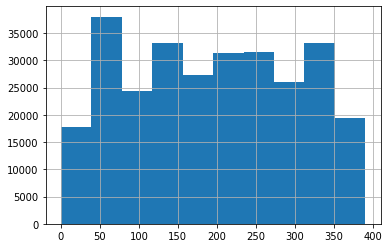

In [37]:
df12['dt'].compute().hist(); # levare? Non so bene a cosa serva, non so manco se si possa usare per discutere la non uniformità delle traiettorie che facciamo passare... Non è detto ci sia correlazione fra l'angolo e i drift times, o almeno non una banale

## Local fit plot
To see whether the above algorithm is able to find the true x best we plot the detector, the hits associated to some (orbit, chamber) pairs and the resulting regression line.        
As mentioned above the `fit` function by definition implements an orthogonal reflection wrt the first bisector, hence another orthogonal reflection is needed to compensate; as already said it suffices to recompute the line parameters using 
\begin{equation}
  m' = \frac{1}{m}
\end{equation}
\begin{equation}
  q' = -\frac{q}{m}
\end{equation}
Also notice that since the following function plots individual chambers there's no need to account for the vertical offset due to multiple chambers, so for simplicity we subtract the correction term added before in order to adopt a simpler reference frame to plot the event.

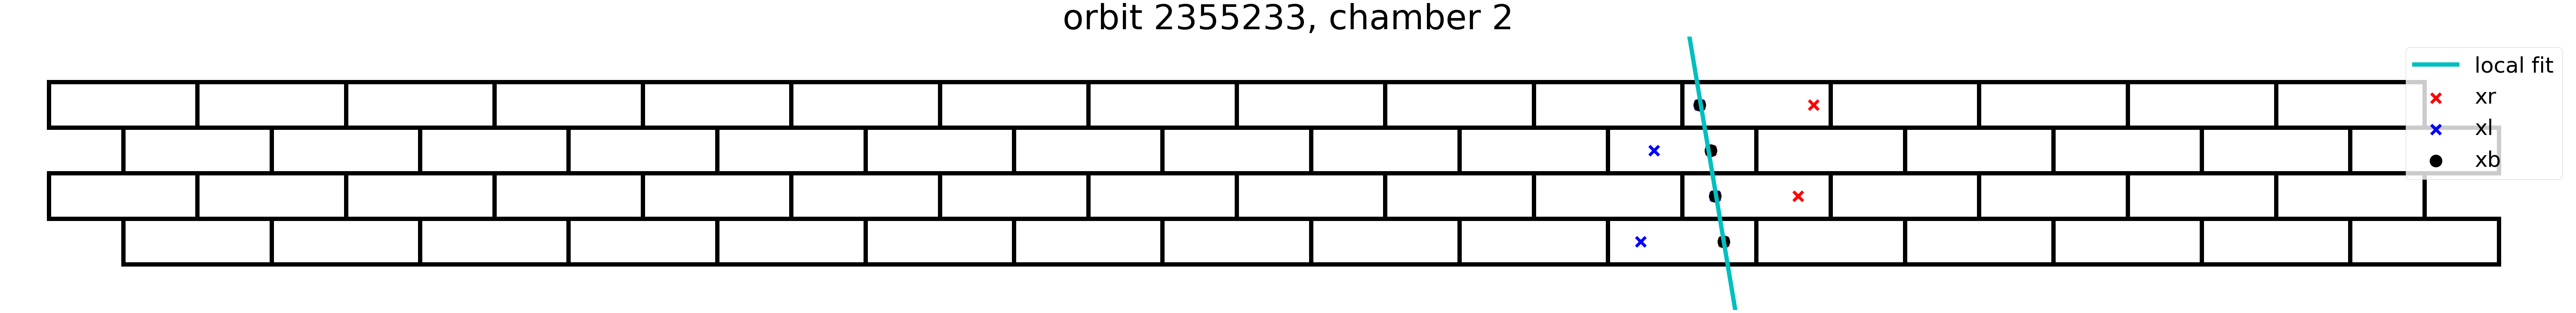

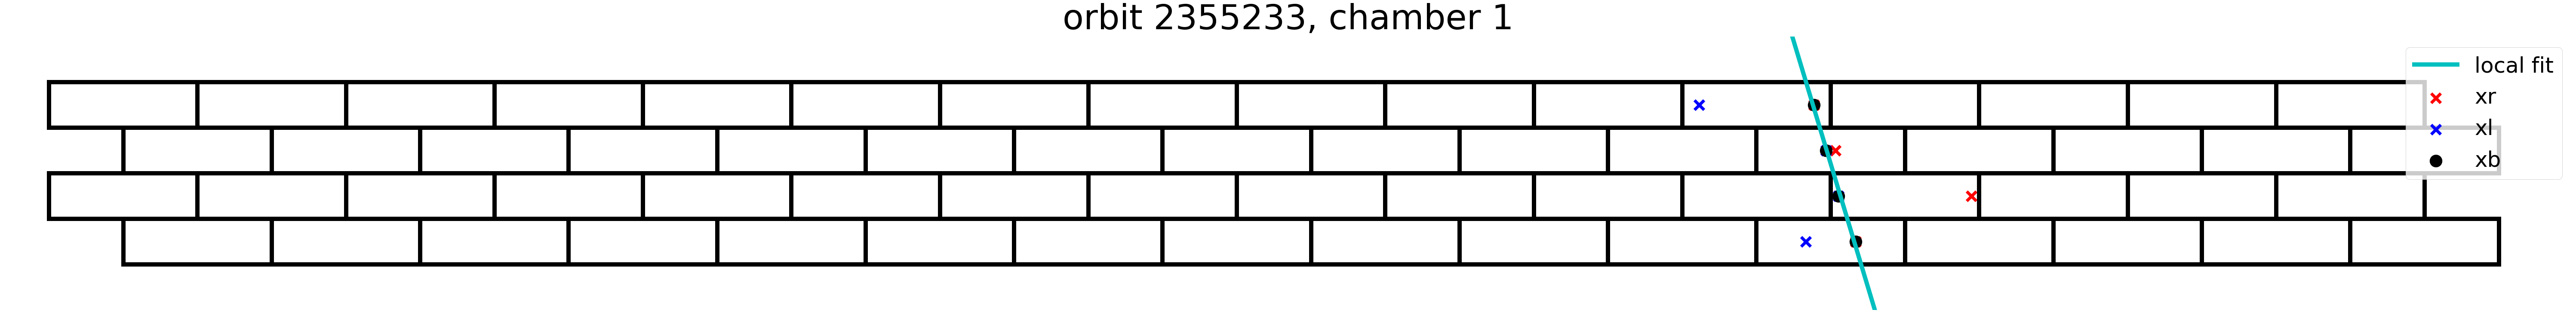

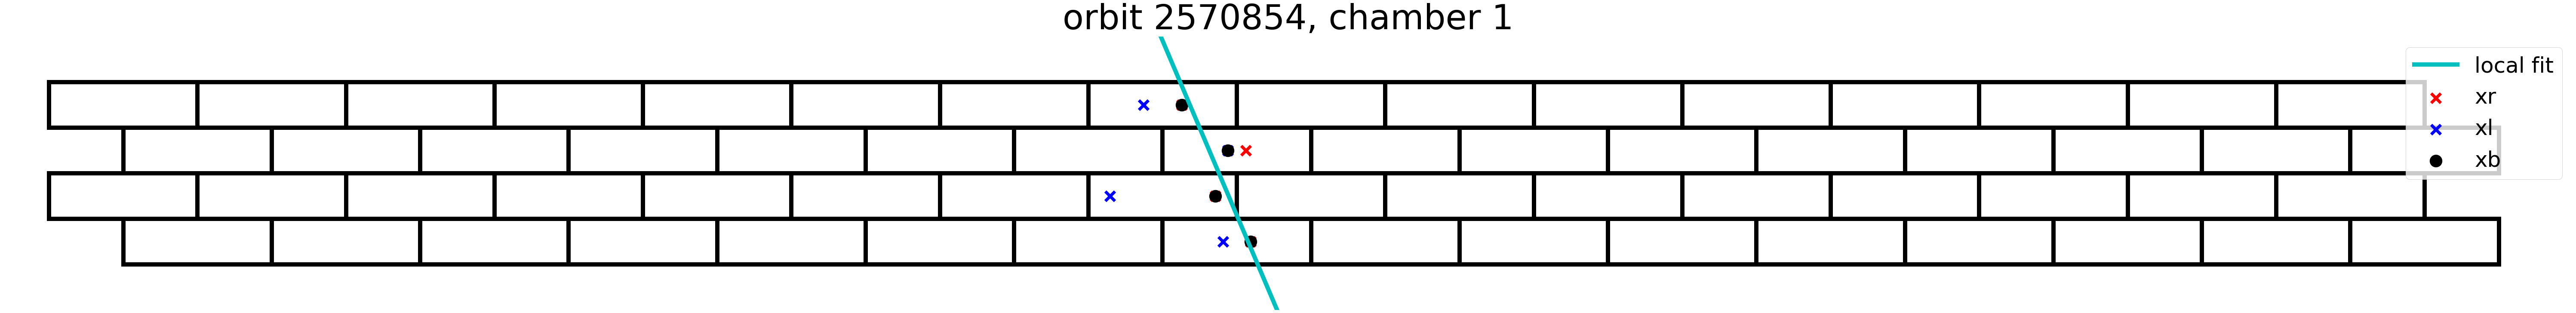

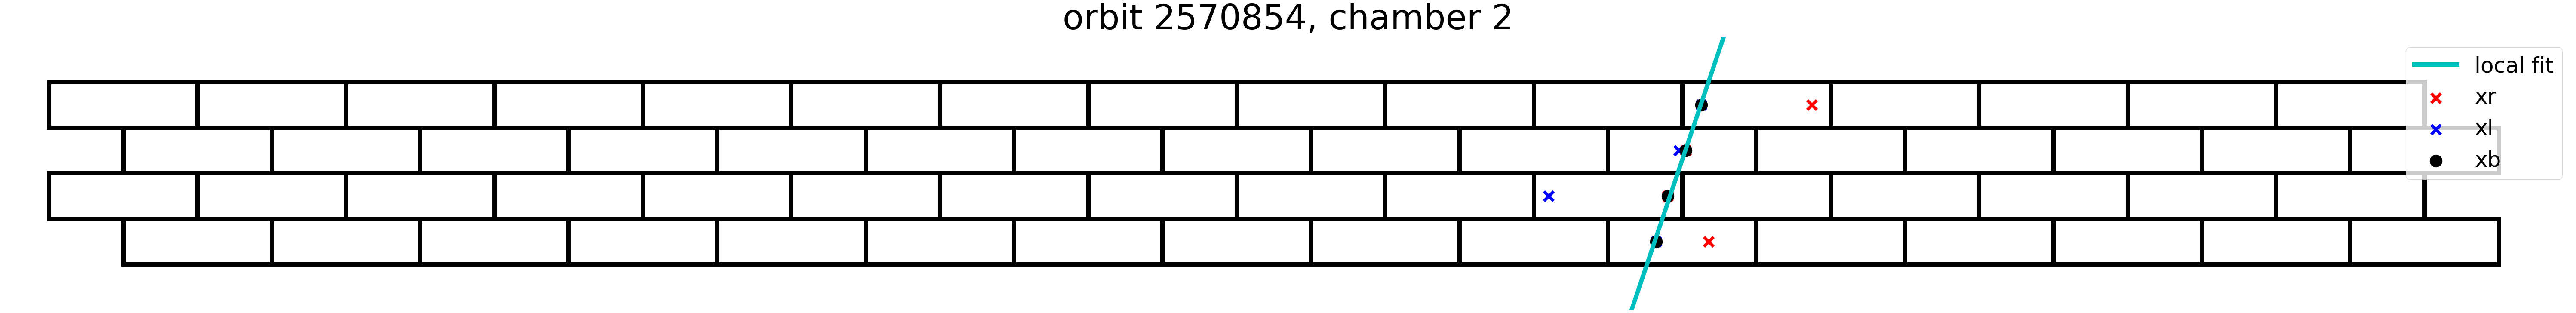

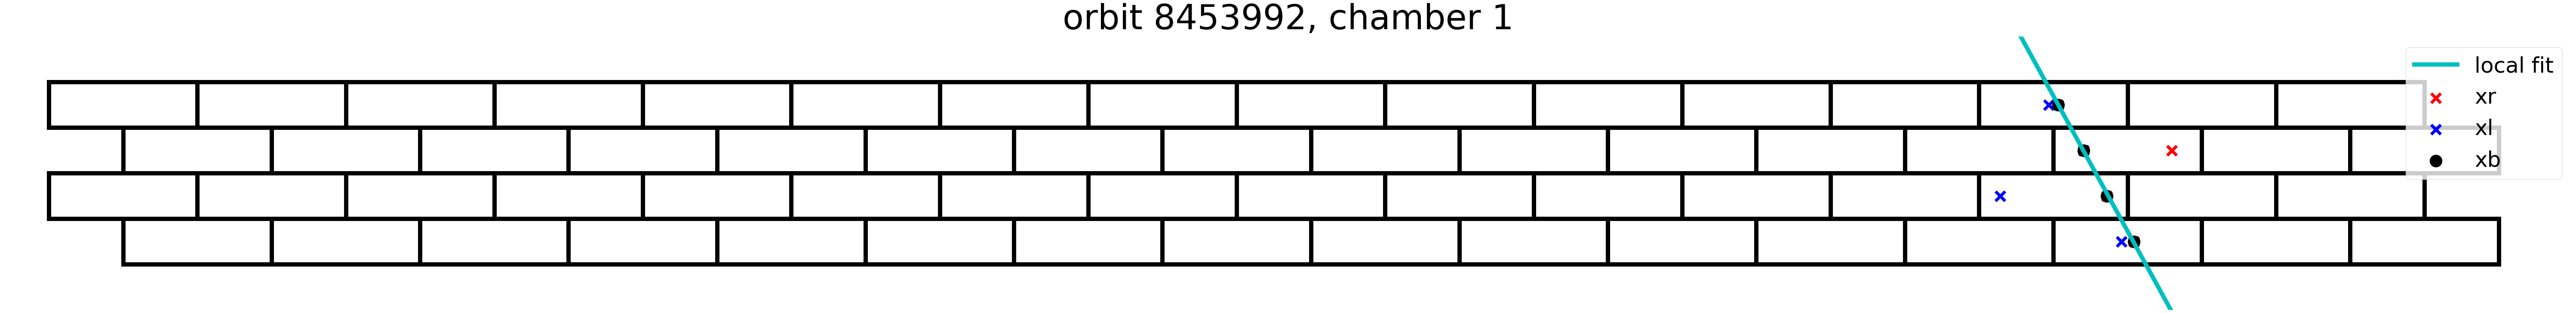

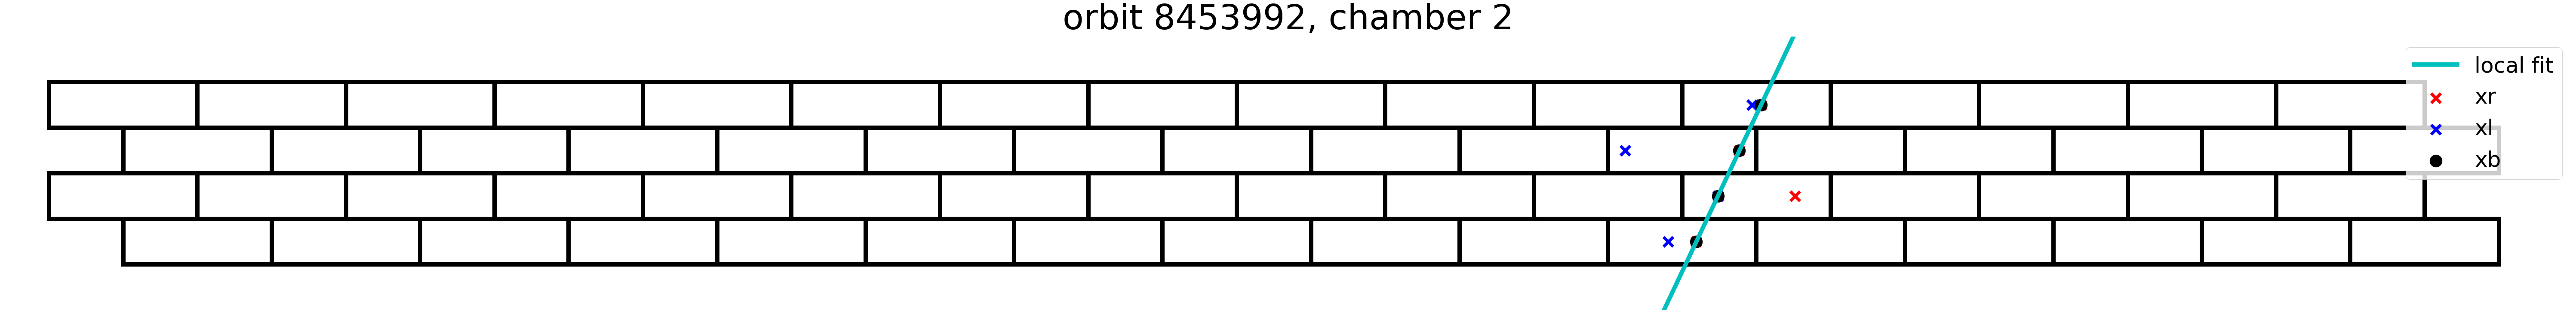

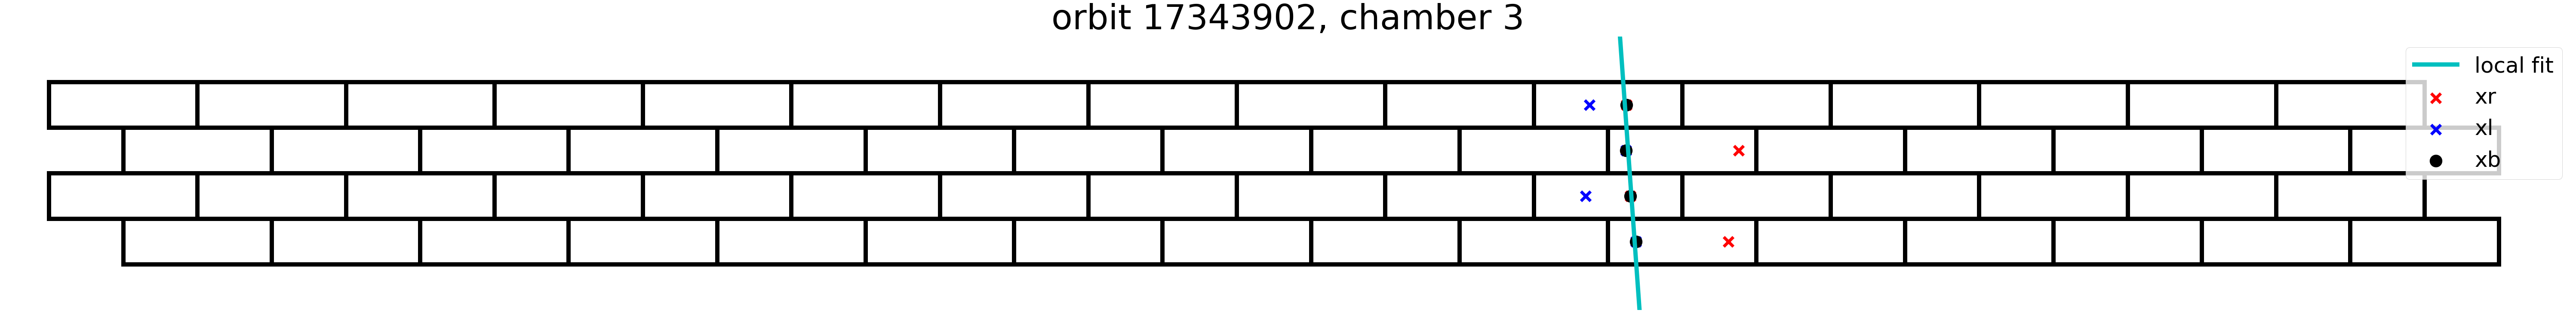

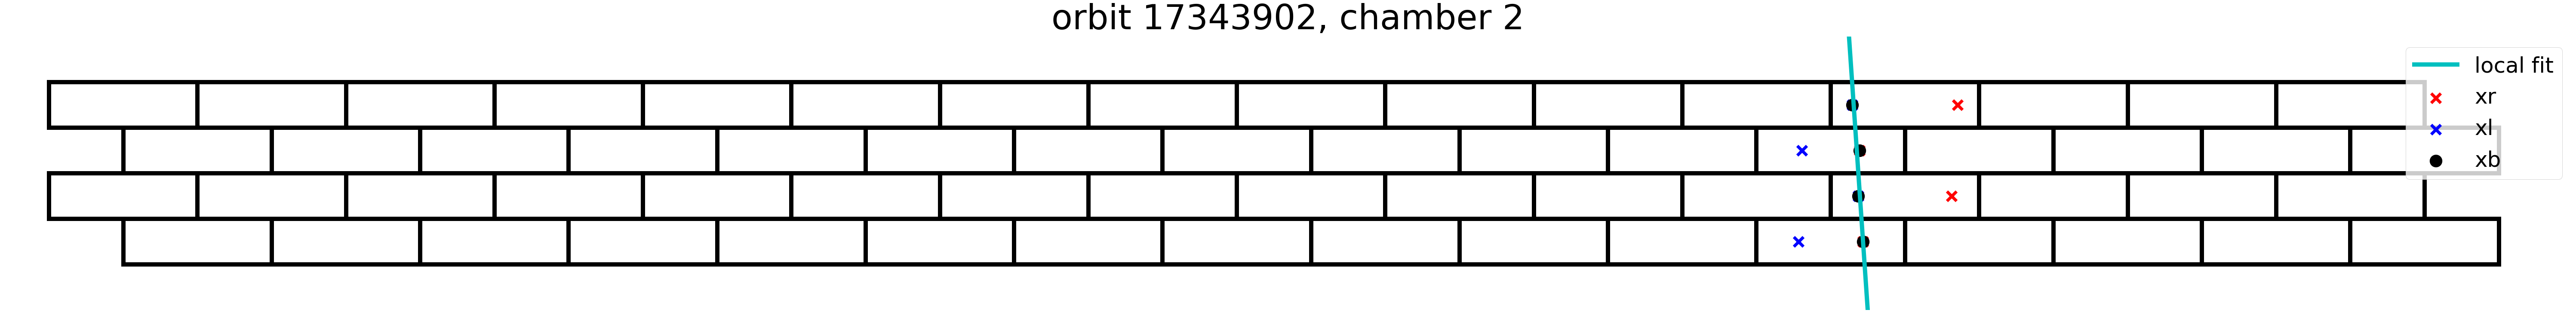

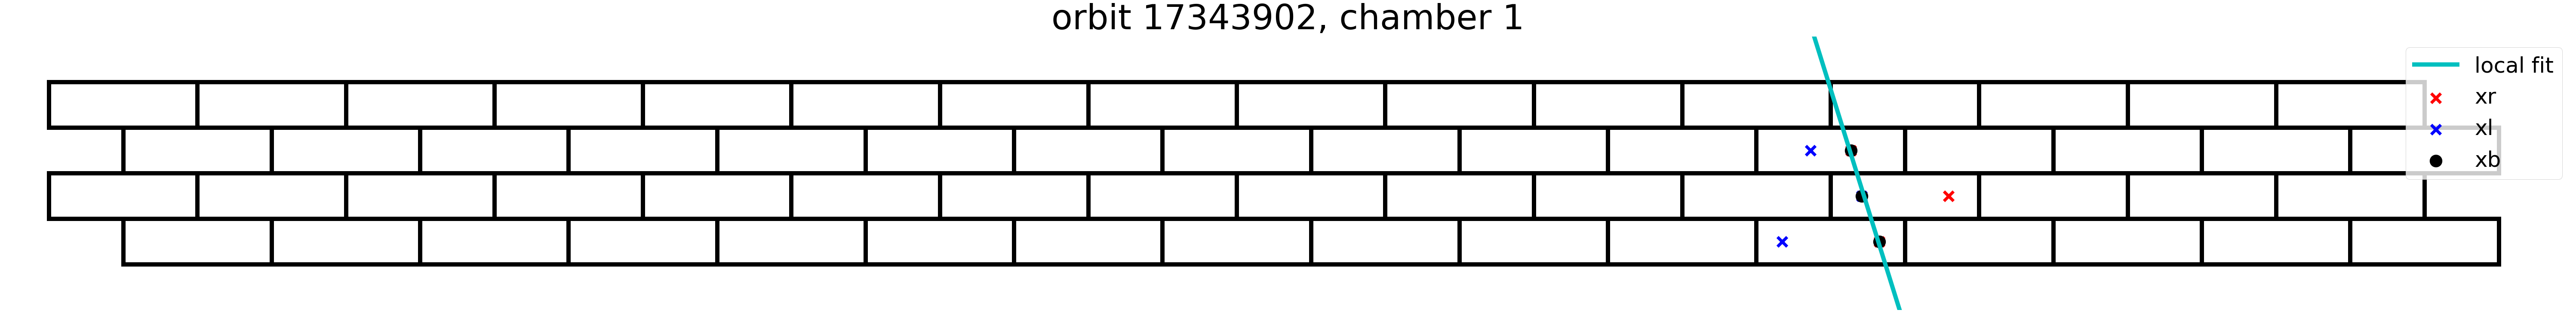

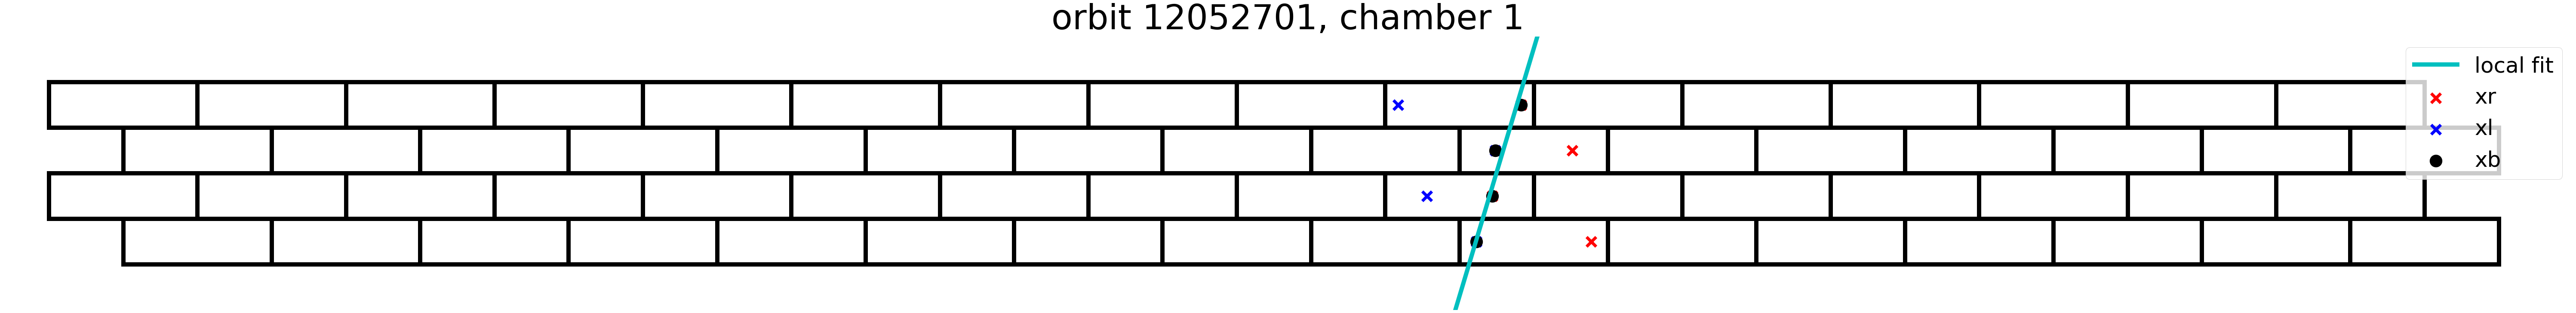

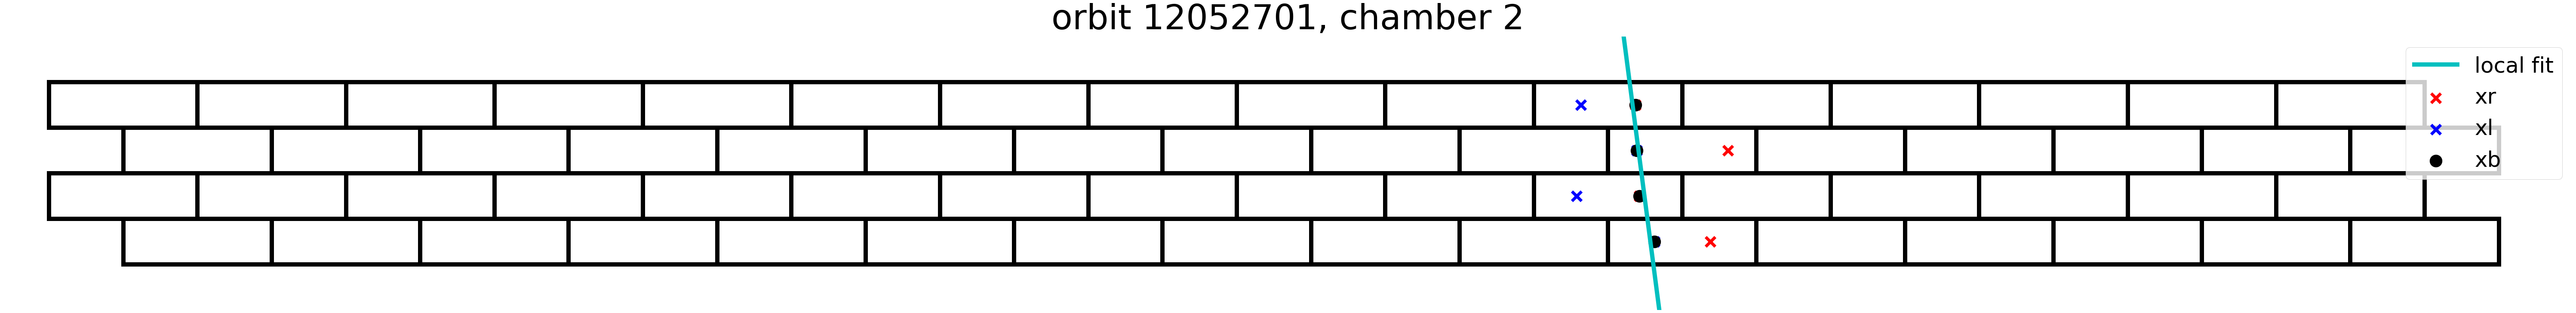

In [38]:
def plot_local_fit(event, plot_fit = True) : # event must contain a single orbit AND a single chamber
    fig, ax = plt.subplots(figsize = (1.5*4.2*17, 1.5*1.3*6)) 

    # dimensions of one cell
    dx = 42
    dz = 13

    # these 4 (x_i, z_i) pairs represent the coordinates of the leftmost, bottommost point of each layer (we plot a single chamber since this is a local fit)
    x2 = x4 = np.arange(16)*dx 
    x1 = x3 = x2 + dx/2 
    [z1, z2, z3, z4] = np.arange(4)*dz  

    X = np.vstack((x1, x2, x3, x4)) # every row of this array represents a layer
    Z = np.array([z1, z2, z3, z4])  # every row of this array represents a layer
    
    # detector plot
    ax.set_xlim(-13, 42*16 + 42)
    ax.set_ylim(-13, (13*4 + 13))
    for i in range(4) : # 4 layers in 1 chamber
        for j in range(16) : # 16 cells in 1 layer
            ax.add_patch(Rectangle((X[i][j], Z[i]), dx, dz, linewidth = 10, edgecolor = 'black', facecolor = 'none')) 
            ax.axis('off')

    xr, xl, z = event.xr, event.xl, event.z.to_numpy() - z_offset[event.chamber.iloc[0]]

    ax.scatter(xr, z, marker = "x", c = "red" , s = 500, linewidth = 7, label = 'xr') #
    ax.scatter(xl, z, marker = "x", c = "blue" , s = 500, linewidth = 7, label = 'xl') #
    if plot_fit :
        xb = event.xb.to_numpy()
        ax.scatter(xb, z, c = "black", s = 500, linewidth = 7, label = 'xb') #

        # local fit
        slope, intercept = fit(z, xb)
        m, q = 1/slope, -intercept/slope # orth. reflection formulae

        def xplot(m, q) :
            zmin, zmax = -20, 13*4+20 # it's easier to specify zmin and zmax than the corresponding x's, since the former are simply a bit below/above the detector whereas the latter are event-dependent
            return np.array([(zmin - q)/m, (zmax - q)/m]) # by inverting z = mx+q one finds (z-q)/m = x, from whence the x's corresponding to zmin and zmax can be found

        ax.plot(xplot(m, q), m*xplot(m, q) + q, 'c', label = 'local fit', linewidth = 10)

    ax.set_title(f'orbit {event.orbit.iloc[0]}, chamber {event.chamber.iloc[0]}', fontsize = 80)
    ax.legend(loc = 'upper right', fontsize = 50)
    return ax

first_orbits = df12.orbit.unique().head()
for orbit in first_orbits :
    tmp = df12[df12.orbit == orbit].compute()
    for ch in tmp.chamber.unique() :
        plot_local_fit(tmp[tmp.chamber == ch])

We notice that the algorithm is indeed able to find the correct value for `xb`, and that some events are "cleaner" than others - in the sense that some events' hits better align with the regression line.

# 2D Global Fit
Once the local-track selection has been performed per each orbit and Chamber the hits have been univocally placed in the detector geometry; this means that now a "global-track" fit can be performed (using only chambers 0, 2, 3, i.e. the ones measuring the same view). This is useful because it allows us to e.g. estimate the detector resolution by comparing local and global fits. 

## The "2D filter": removing chamber 1 and ensuring at least two chambers are active
As mentioned in the project assignment chamber 1 is rotated 90°, hence it measures tracks on the $yz$ plane - whereas chambers 0, 2 and 3 measure tracks on the $xz$ plane. While having a rotated chamber is useful in order to construct a 3D reconstruction it also means that hits in chamber 1 must be temporarily dropped, as they're irrelevant for the 2D global fit.             
Notice that once we drop chamber 1 hits we can no longer guarantee that every orbit in our dataset is made up of at least 2 active chambers, hence we need to re-apply the `min_n_active_chambers` filter.              
Since we're using the same function defined above one could argue we're wasting resources by repeating something that could have been done in one take earlier, but we remark that our choice makes sense since the tasks "ensuring no only-1-active-chamber-events are in the dataset" and "ensuring that once we temporarily drop chamber 1 a 2D global fit can still be done" are very different tasks, and it is reasonable to separate them.

In [39]:
df2d = df12.copy()
df2d = df2d[df2d.chamber != 1] # removing chamber 1
df2d = df2d.groupby('orbit').apply(min_n_active_chambers, meta = slim_dtypes).dropna().reset_index(drop = True).astype(slim_dtypes) # ensuring at least 2 active chambers exist, otherwise there is no distinction between the local and the global 2d fits

## 2D Global Fit Plot
Before carrying out a more thorough analysis we plot a few of these global 2d fits, so that we may get a feel for them. In order to do so we represent the detector in its entirety (i.e. all 4 chambers, even though chamber 1 is only a placeholder) and use the same "global" reference frame which accounts for the vertical chamber offset (i.e. this time we leave the correction term in $z$); then we plot a local fit per active chamber, then a global fit made using every hit in the event irrespective of its chamber.                
Also to better give a sense of scale this time we also plot axes with markers, so that we can appreciate the physical extent of the detector.

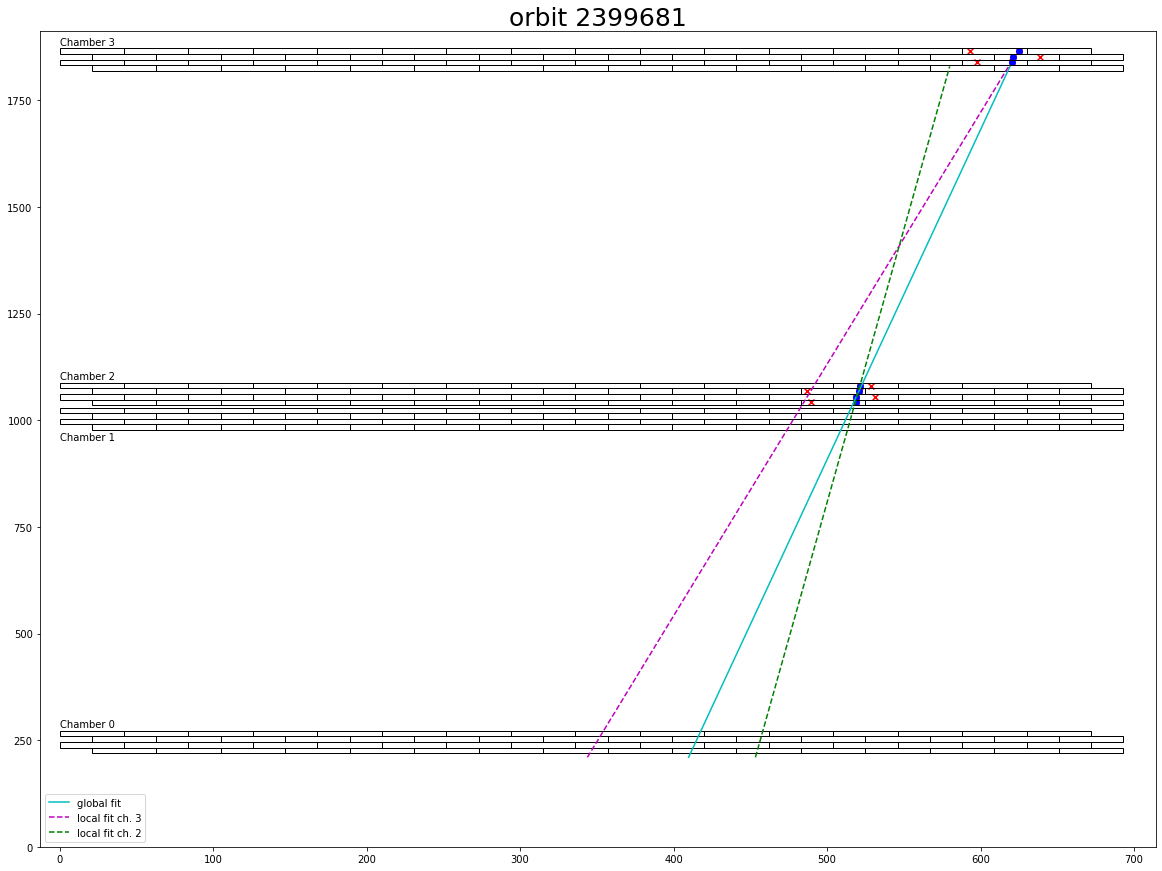

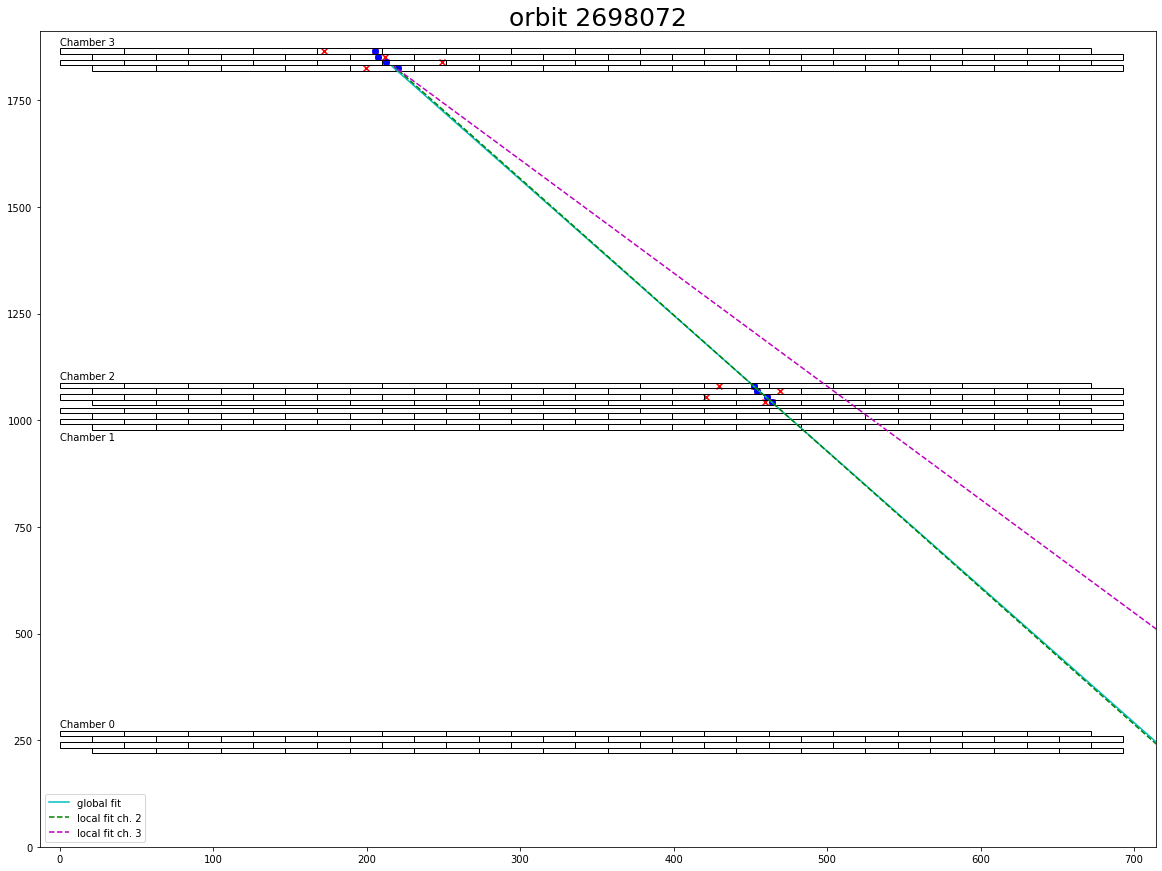

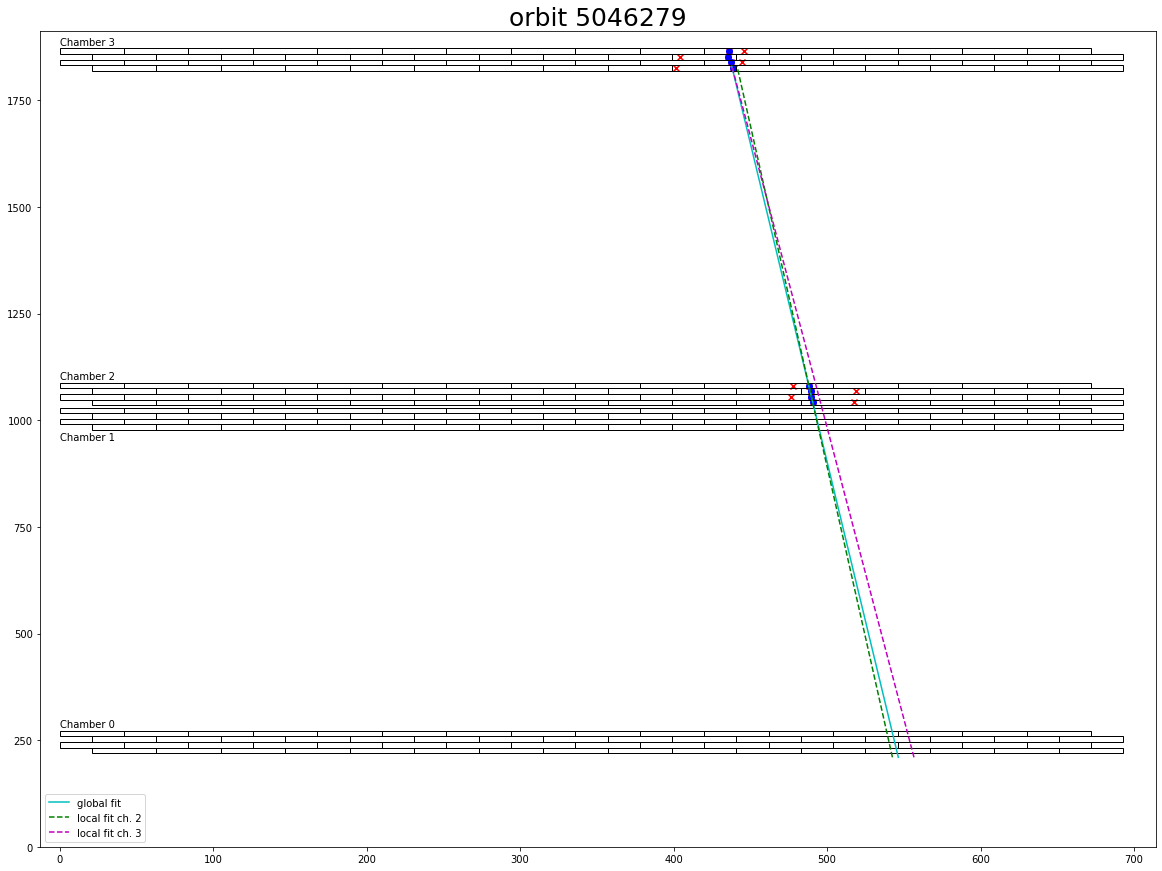

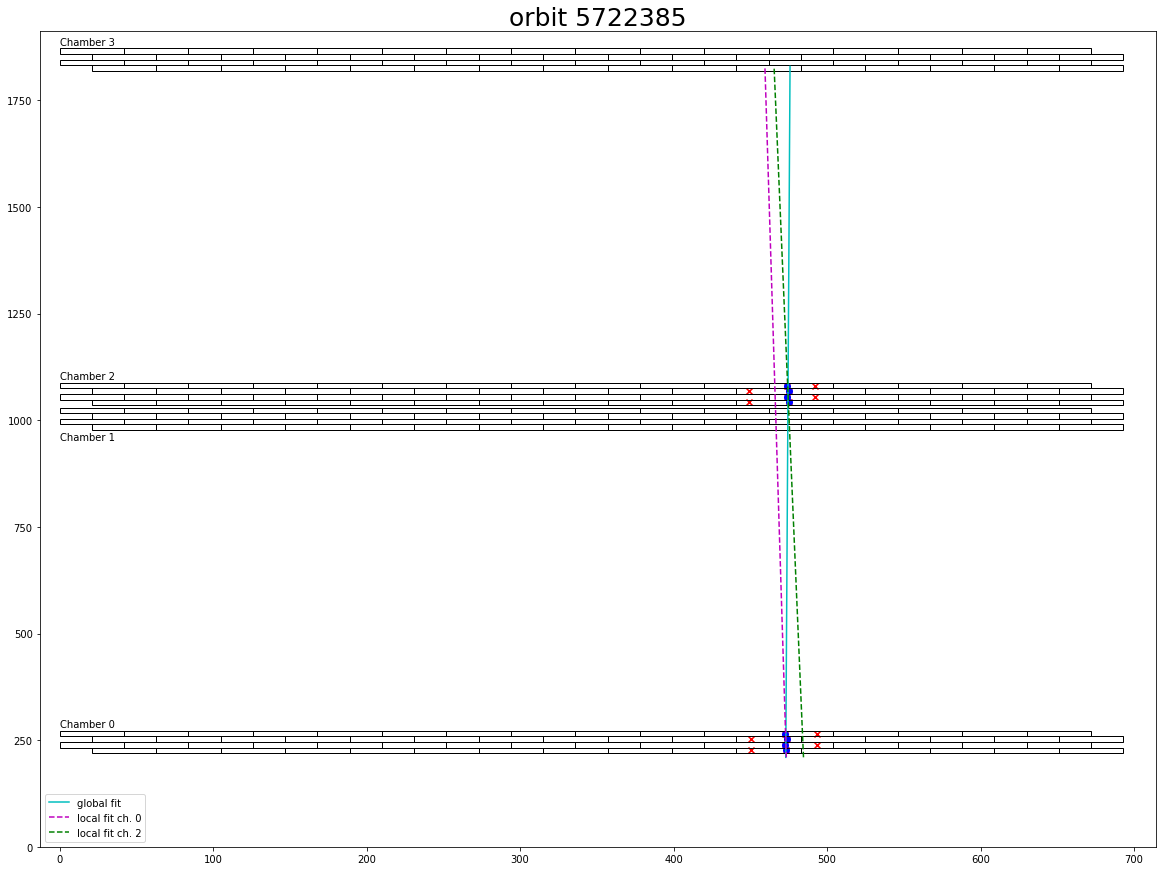

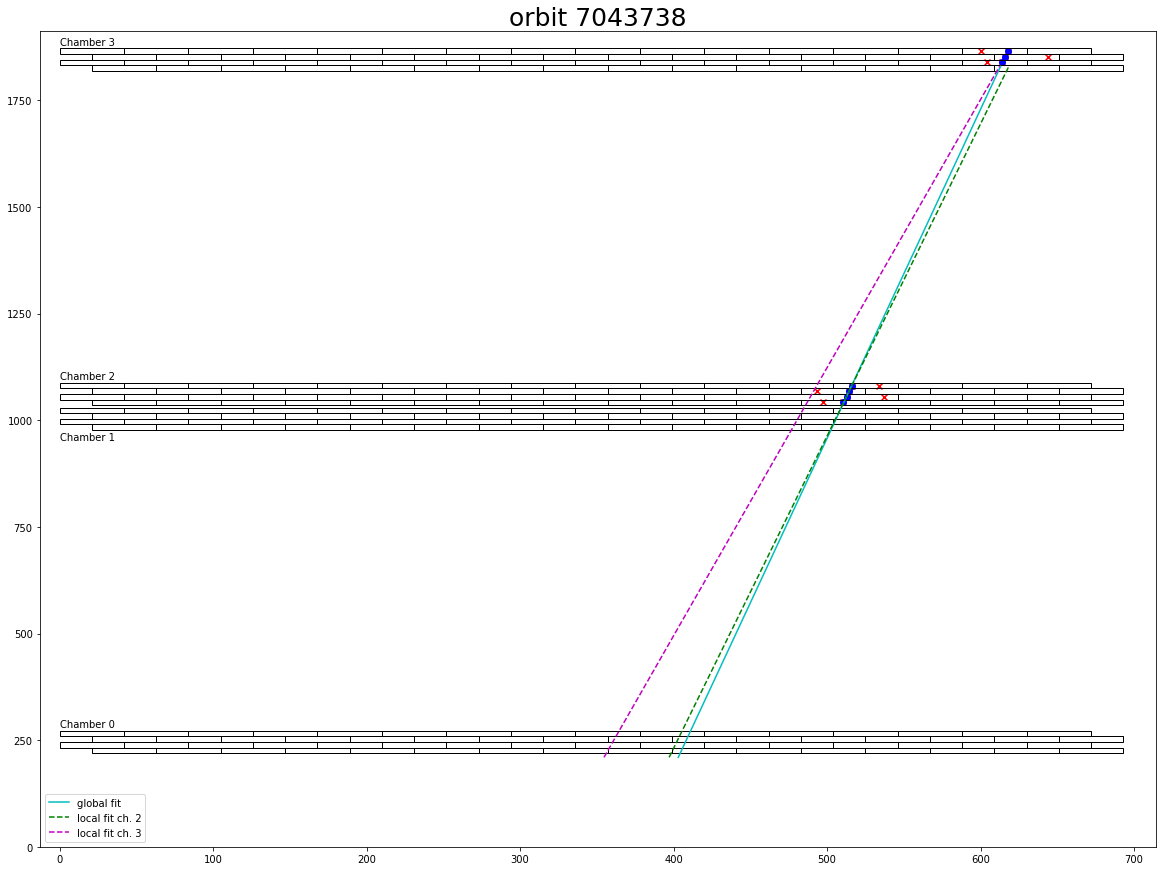

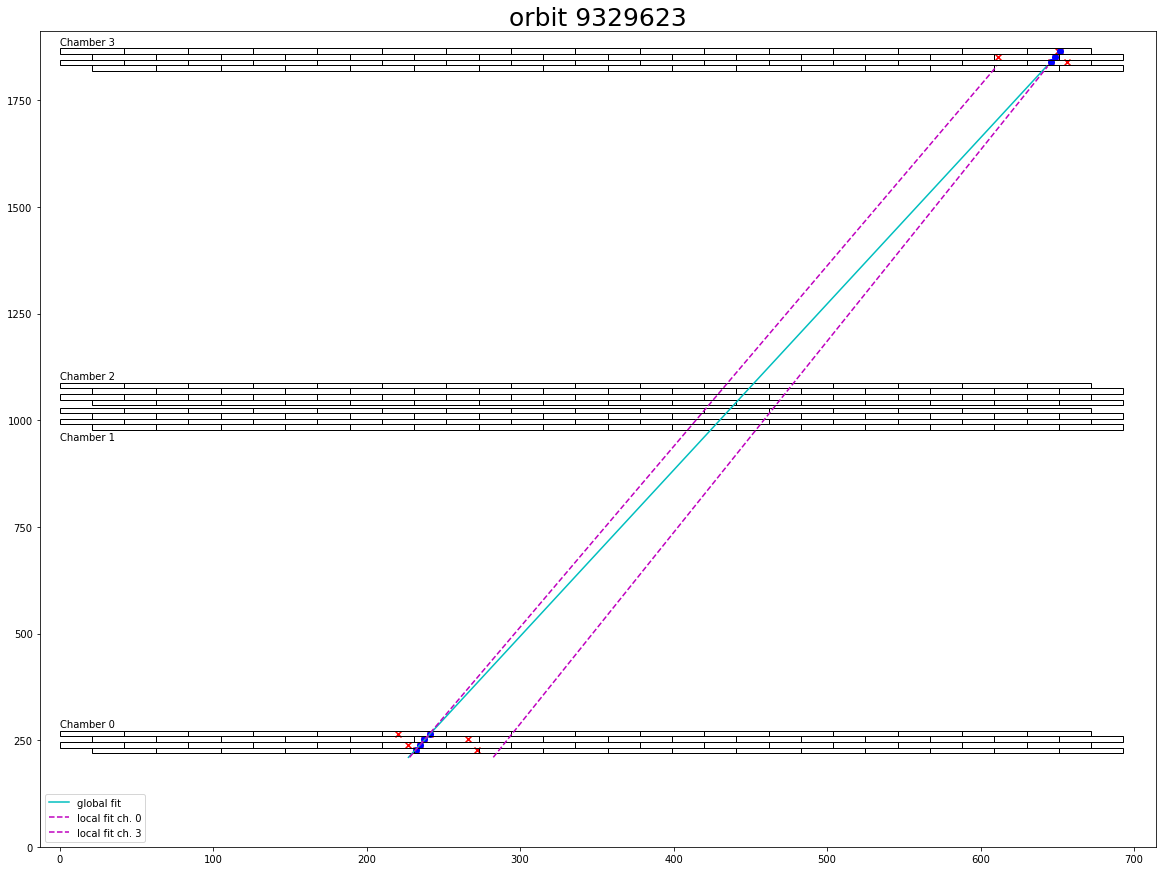

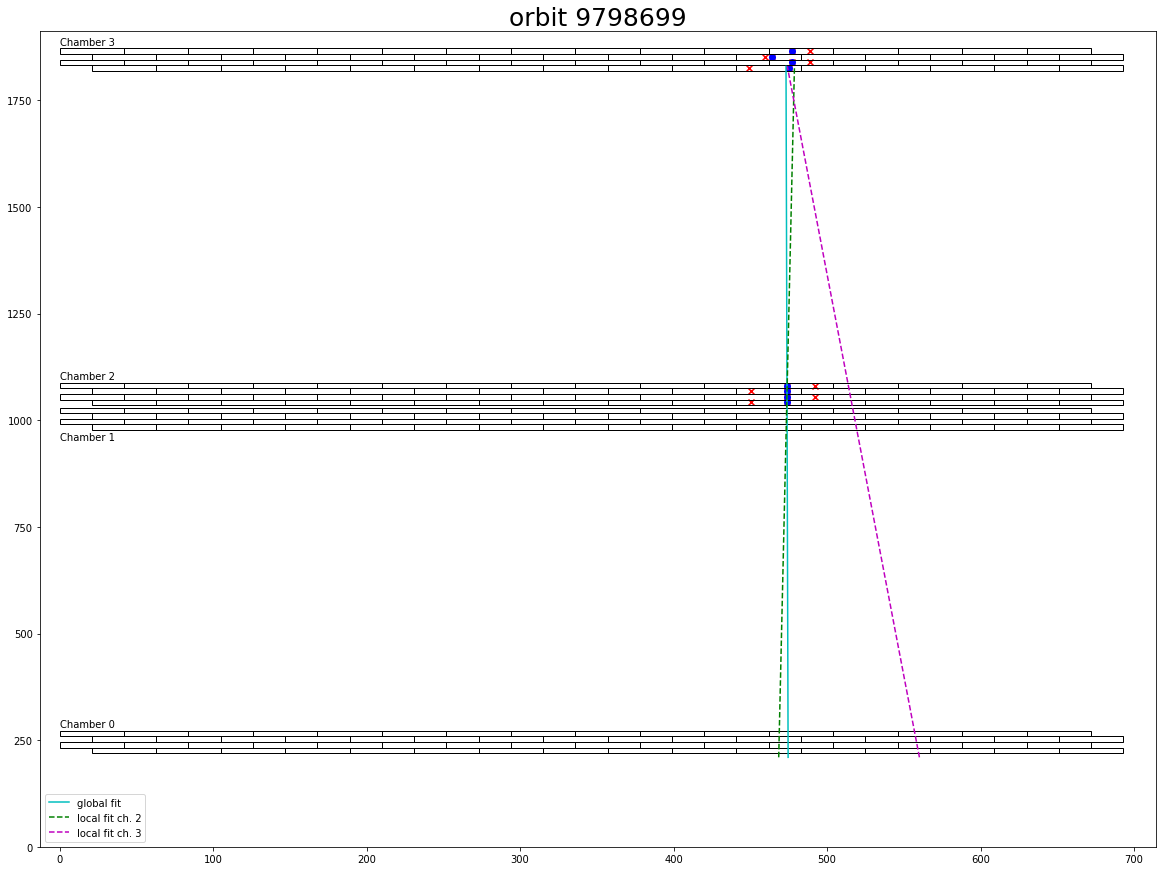

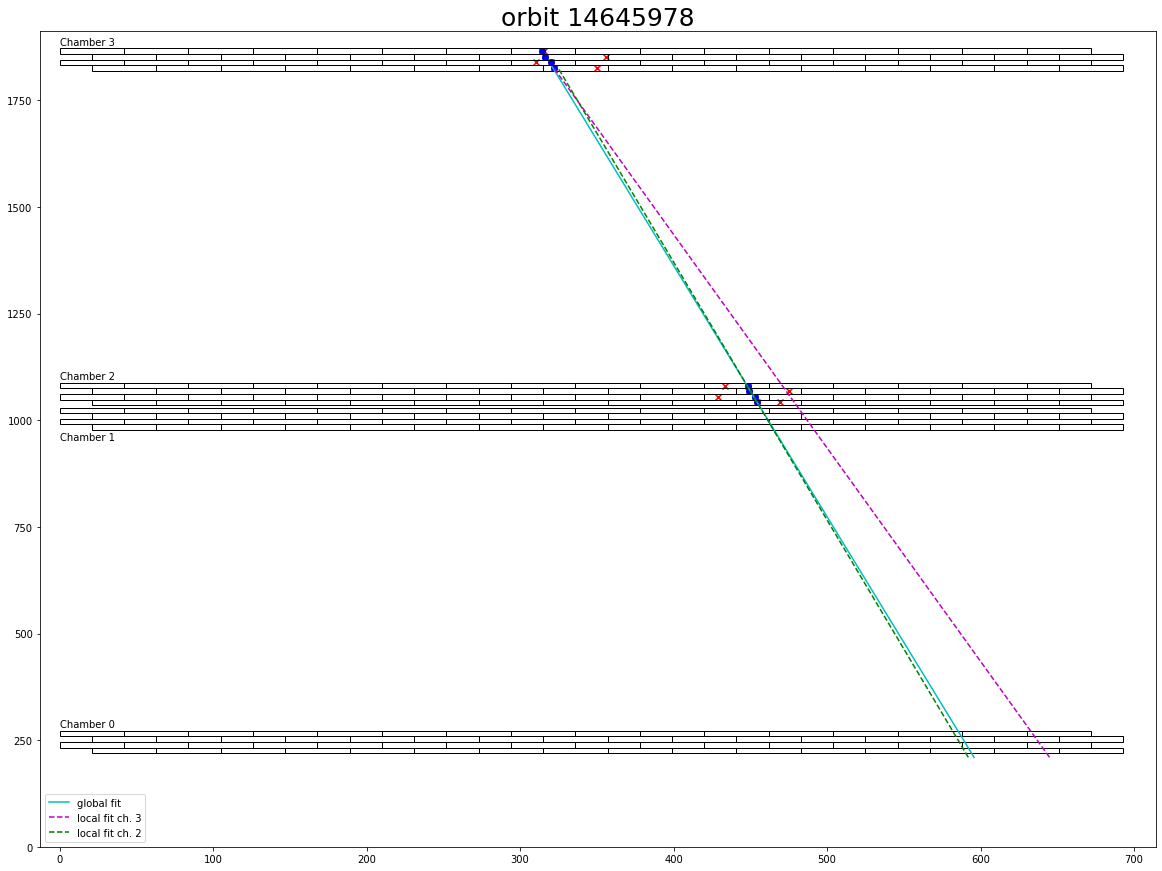

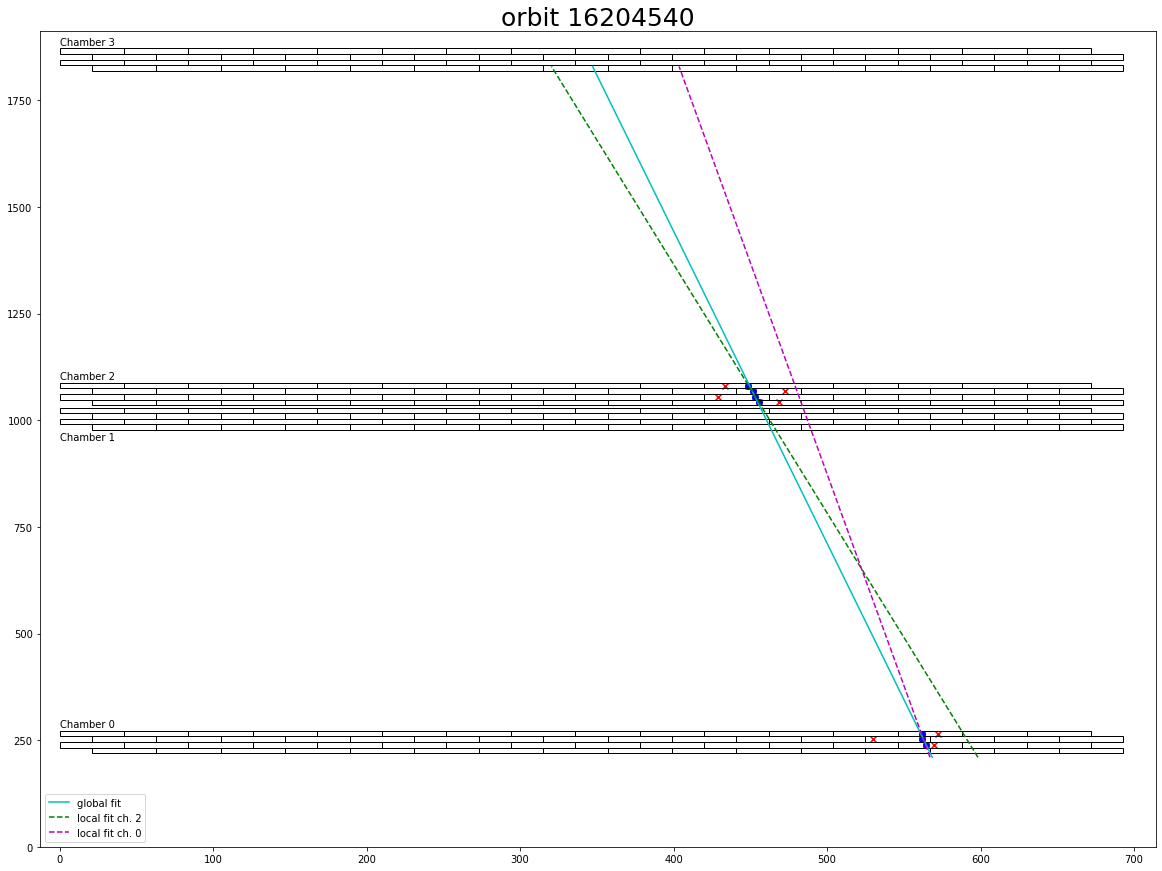

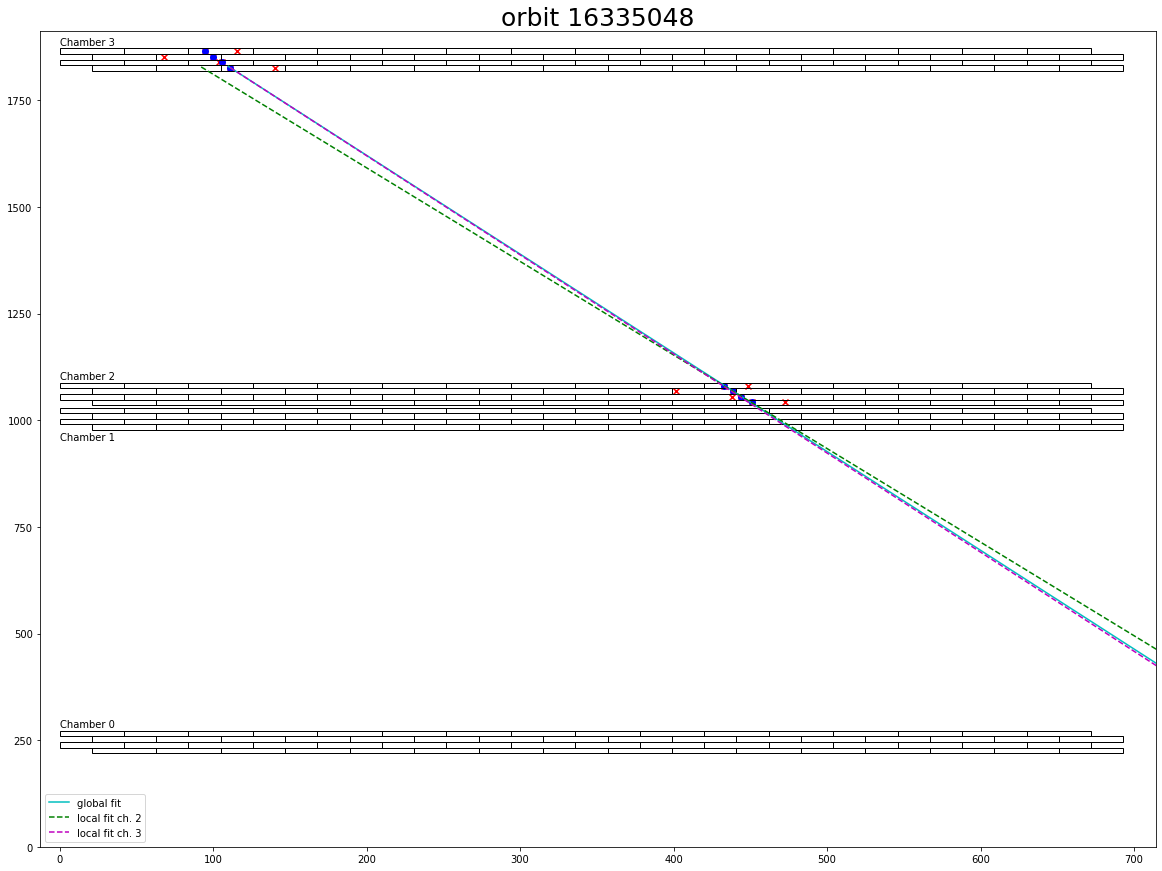

In [40]:
def plot_global_fit(event) :
    fig, ax = plt.subplots(figsize = (20, 15)) 

    # dimensions of one cell
    dx = 42
    dz = 13

    # draw the detector
    ax.set_xlim(-13, 42*16 + 42)
    ax.set_ylim(0, z_offset[-1] + 13*4 + 40) # a bit below chamber 0, a bit above chamber 3

    # these 4 (x_i, z_i) pairs represent the coordinates of the leftmost, bottommost point of each layer (we plot a single chamber since this is a local fit)
    x2 = x4 = np.arange(16)*dx 
    x1 = x3 = x2 + dx/2

    X = np.vstack((x1, x2, x3, x4)) # every row of this array represents a layer
    Z = np.array([np.arange(4)*dz +z_offset[i] for i in range(4)])

    for ch in range(4) : # 4 chambers
        for i in range(4) : #  4 layers in 1 chamber
            for j in range(16) : # 16 cells in any 1 given layer
                ax.add_patch(Rectangle((X[i][j], Z[ch][i]), dx, dz, edgecolor = 'black', facecolor = 'none')) 
                #ax.axis('off') # this time we plot the axes to give a sense of scale

    ax.scatter(event.xr, event.z, marker = "x", c = "red") 
    ax.scatter(event.xl, event.z, marker = "x", c = "red") 
    ax.scatter(event.xb, event.z, c = "blue") 

    # global fit
    slope, intercept = fit(event.z.to_numpy(), event.xb.to_numpy())
    M, Q = 1/slope, -intercept/slope

    def xplot(m, q) :
        zmin, zmax = z_offset[0] - 10, z_offset[-1] + 10
        return np.array([(zmin - q)/m, (zmax-q)/m])

    ax.plot(xplot(M, Q), M*xplot(M, Q) + Q, 'c', label = 'global fit') # by inverting z = mx+q one finds (z-q)/m = x, from whence the x's corresponding to zmin and zmax can be found

    # local fit
    markers = ['b--', 'g--', 'm--']
    for ch in event.chamber.unique() :
        slope, intercept = fit(event[event.chamber == ch].z.to_numpy(), event[event.chamber == ch].xb.to_numpy())
        m, q = 1/slope, -intercept/slope
        ax.plot(xplot(m, q), m*xplot(m, q)+ q, markers[ch-1], label = f'local fit ch. {ch}')


    ax.set_title(f'orbit {event.orbit.iloc[0]}', fontsize = 25)
    ax.legend(loc = 'lower left', fontsize = 10)
    ax.text(x = 0, y = z_offset[3] + 60, s = "Chamber 3", fontsize = 10)
    ax.text(x = 0, y = z_offset[2] + 60, s = "Chamber 2", fontsize = 10)
    ax.text(x = 0, y = z_offset[1] -25, s = "Chamber 1", fontsize = 10)
    ax.text(x = 0, y = z_offset[0] + 60, s = "Chamber 0", fontsize = 10)
    return ax

first_orbits_2d = df2d.orbit.unique().head(10)

for orbit in first_orbits_2d :
    plot_global_fit(df2d[df2d.orbit == orbit].compute())

Notice there's an interesting balance between event with very similar lines and events with a larger slope difference; we'll analyze this in greater quantitative detail in the "angles" section below.

## Residuals
There are at least two ways to analyze the quality of the global 2d fits: residuals and angles - the latter of which deserves its own section, so for now let's discuss residuals.          
Residuals in a fit of any kind are defined according to this equation:
\begin{equation}
  \text{residuals} = \text{observed value} - \text{predicted value}
\end{equation}
which in our case becomes 
\begin{equation}
  \text{residuals} = x_b - (mz+q)
\end{equation}
These quantities are what we square and sum to compute the $\chi^2$.            
Computing residuals is interesting because it gives us a way to estimate the experimental error on $x$: indeed if we assume the best fit line is the "real" trajectory then the residuals measure how much displaced each hit is due to experimental error.           
Residuals also let us see how much local and global fits agree: in the ideal case we'd obtain 0 for every residual, so the larger the discrepancy from 0 the less "ideal" the overall fit.          
Other possible uses of residuals will be discussed later.

In [41]:
# compute residuals
def residuals(group) :
    slope, intercept = fit(group['z'].to_numpy(), group['xb'].to_numpy()) 
    group['residuals'] = group['xb'] - slope*group['z']-intercept # x_observed - x_predicted
    return group

dfr = df2d.groupby('orbit').apply(residuals, meta = {**slim_dtypes, 'residuals':'f8'}) # obviously chamber 1 needs to be excluded from this, because its residuals would be nonsensical given that they refer to a different fit

In [42]:
dfr = dfr.persist() # useful since we'll need it many times

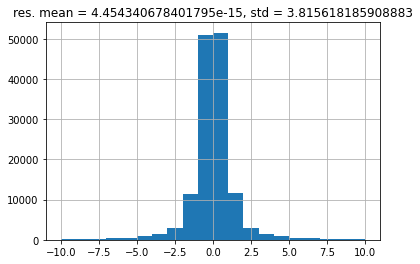

In [43]:
# we convert the residuals column to a pandas series for simplicity
res = dfr['residuals'].compute()
res.hist(bins = 20, range = (-10, 10))
plt.title(f'res. mean = {res.mean()}, std = {res.std()}');

As expected we obtain an almost gaussian distribution - reasonable: positive and negative residuals should be equally likely, and the probability of observing large residuals should fall quickly with the size of the residuals; these two points explain why we obtained a zero-mean gaussian.           
It's interesting to note that almost all residuals are within $\pm 1-3 \ \text{mm}$, which is much less than the half-length of a cell (21 mm); this seems to suggest that the detector is very accurate and that the overall global fit quality is great, but actually this is deceiving; we'll see below a better way to analyze the detector resolution/the experimental error, ecc.                     
For now let's make some other residuals histograms, one per chamber.

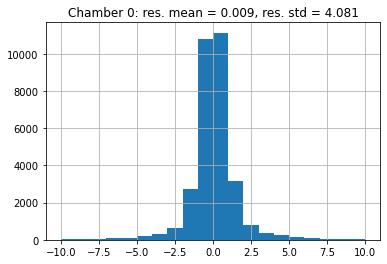

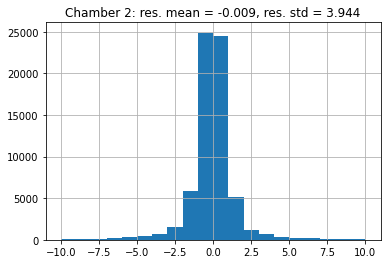

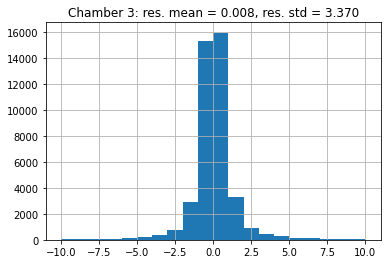

In [44]:
for ch in [0, 2, 3] : # chamber 1 has been temporarily excluded from the dataset
    tmp = dfr.loc[dfr.chamber == ch, 'residuals'].compute()
    plt.figure()
    plt.title(f'Chamber {ch}: res. mean = {tmp.mean():.3f}, res. std = {tmp.std():.3f}')
    tmp.hist(bins = 20, range = (-10, 10));

The histograms are very similar to each other; this tells us that e.g. no chamber underperformed wrt the others.

# Observed angles and detector resolution
The other and more interesting way to analyze fit quality & detector resolution is to compute the angles associated to local/global fits and compare them. In particular we remark that ideally the angle e.g. wrt the vertical associated to the lines computed from local and global regressions would be identical; in practice this doesn't happen, and the larger the difference the worse the fit quality/the detector resolution.        
To apply this we can for example arbitrarily choose to compare the global fit with the local one associated to chamber 2, so we start this section by checking which orbits have an active chamber 2.

In [45]:
# check if chamber 2 is active
if not pure_dask :
    # note that df2d already contains only events with at least 2 active chambers (different from 1) in order to ensure a sensible global fit, so here it suffices to check chamber 2 is active
    orbits_with_ch2_active = df2d[df2d.chamber == 2].orbit.compute()
    dfa = df2d[df2d.orbit.isin(orbits_with_ch2_active)]
else :
    def ch2(group) :
        if 2 in group['chamber'].to_numpy() : 
            return group
        else :
            return None 
    dfa = df2d.groupby('orbit').apply(ch2, meta = slim_dtypes).dropna().reset_index(drop = True).astype(slim_dtypes)

In [46]:
dfa = dfa.persist() # useful since we'll need it multiple times

## $\alpha(m)$ computation
Now before carrying out the analysis mentioned above let us state how the desired angle is computed from the line's slope, and plot an histogram of the observed angles computed this way.         
Let's say that $m$ is the "flipped" slope returned by the `fit` function, and that $\alpha$ is the angle between our line and the vertical. Then with a little geometry it's easy to prove that 
\begin{equation}
  \alpha = \text{sign}(m) \left(\frac{\pi}{2} - |\arctan(1/m)|\right)
\end{equation}
This equations correctly accounts for positive and negative finite slopes; if $m$ is 0 we of course identically set $\alpha = 0$ with no need for equations.

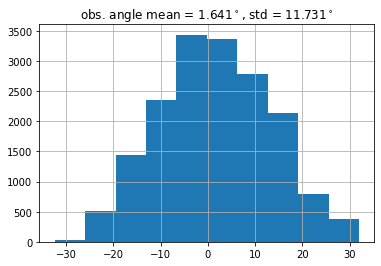

In [47]:
pi2 = np.pi/2

# observed angles
def angle(group) : # in radians
    m, q = fit(group.z.to_numpy(), group.xb.to_numpy())
    if m != 0 :
        return (pi2 - np.abs(np.arctan(1/m)))*np.sign(m)
    else :
        return 0 # wrt the vertical, otherwise it would need to be np.pi/2

obs_angles = 180/np.pi*(dfa.compute().groupby('orbit').apply(angle)) # in degrees
obs_angles.hist() # notice that we need to use pandas because apparently dask doesn't like if we .apply() functions that transform dataframes into series. This actually makes it simpler, though
plt.title(f'obs. angle mean = {obs_angles.mean():.3f}$^\circ$, std = {obs_angles.std():.3f}$^\circ$');

## Are angles beyond $\pm 30^\circ$ really impossible to observe?
We obtained a resonable distribution: symmetric around zero (positive slopes are just as likely as negative ones), and approximately normal (consistent with the fact that our filters favor almost vertical trajectory and discard almost horizontal ones).

It's very important not to misinterpret the above histogram: in particular we remark that *the fact that every angle is $\lesssim \pm 30^\circ$ does NOT mean that every particle trajectory was within $\pm 30^\circ$ or that our detector was insensitive beyond $\pm 30^\circ$*; the above histogram simply means that *our pipeline only lets through trajectories with slopes within that range*.           
Of course it could be that the trajectories are actually always all in that range, or the detector is truly insensitive outside this range; the point we're trying to make is simply that the above histogram doesn't provide enough evidence to back these claims.

## Resolution computation (global vs chamber 2 local fit)
Now that we stated the equation for $\alpha(m)$ we are ready to compute the differences between $\alpha_g$ and $\alpha_2$, where these two angles are those obtained from the global and chamber 2 fits, respectively.

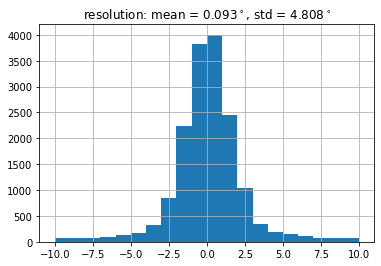

In [48]:
def resolution(group) :
    ch2_x, ch2_z = group[group['chamber'] == 2].xb.to_numpy(), group[group['chamber'] == 2].z.to_numpy()
    m, q = fit(ch2_z, ch2_x) # local
    M, Q = fit(group.z.to_numpy(), group.xb.to_numpy()) # global

    if m != 0 :
        local_fit_angle = np.sign(m)*(pi2 - np.abs(np.arctan(1/m))) 
    else :
        local_fit_angle = 0 # wrt the vertical, in radians

    if M != 0 :
        global_fit_angle = np.sign(M)*(pi2 - np.abs(np.arctan(1/M))) 
    else :
        global_fit_angle = 0

    return global_fit_angle - local_fit_angle # angle in radians wrt the vertical

diff_angles = 180/np.pi*(dfa.compute().groupby('orbit').apply(resolution)) # once again we need to switch to a pandas series
diff_angles.hist(bins = 20, range = (-10, 10))
plt.title(f'resolution: mean = {diff_angles.mean():.3f}$^\circ$, std = {diff_angles.std():.3f}$^\circ$');

Let's print a more detailed summary of the above histogram.

In [49]:
def print_resolution_summary(diff) :
    print(f'resolution: mean = {diff.mean():.3f}°, std = {diff.std():.3f}°')
    print(f'hits with resolution within ±10°: {np.count_nonzero(diff.abs() < 10)/len(diff):.3%}') 
    print(f'hits with resolution within ±5°: {np.count_nonzero(diff.abs() < 5)/len(diff):.3%}')
    print(f'hits with resolution within ±2°: {np.count_nonzero(diff.abs() < 2)/len(diff):.3%}')

print_resolution_summary(diff_angles)

resolution: mean = 0.093°, std = 4.808°
hits with resolution within ±10°: 95.103%
hits with resolution within ±5°: 89.666%
hits with resolution within ±2°: 72.734%


We obtained that most event have global vs local angles discrepancies within 5-10°. This is a decent estimate for the detector resolution for this experiment, but once again we have to remark that *this result cannot be uncoupled from the data processing pipeline*. It may really be that this is the detector resolution, but since we did not obtain these numbers e.g. through a calibration phase (but rather by analyzing *arbitrarily filtered* data) we simply cannot be really sure. Later we'll offer another example as to why this detector resolution estimate is at least partly arbitrary; for now it's enough to state that this estimate heavily depends on the way we *chose* to filter the data.

## Resolution computation (global vs average of the local fits)
One may also ask what happens if instead of comparing the global fit to chamber 2's local one we simply compared the global fit to the average of the angles obtained from every possible local fit. On one hand this is interesting because it could reveal potential asymmetries between chambers, and on the other makes the algorithm a bit simpler (since we no longer need to check whether chamber 2 was active in any given orbit).

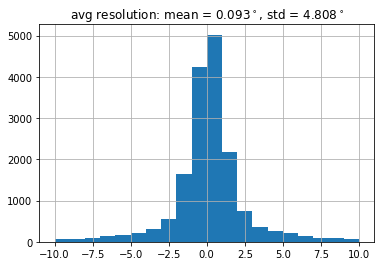

In [50]:
# this time instead of comparing the global angle with chamber 2's one we compare it every local angle and take the average in the end

def average_resolution(group) :
    M, Q = fit(group.z.to_numpy(), group.xb.to_numpy()) # global
    if M != 0 :
        global_angle = np.sign(M)*(pi2 - np.abs(np.arctan(1/M)))
    else :
        global_angle = 0 # wrt the vertical

    differences = np.zeros(len(group.chamber.unique()))

    for i, ch in enumerate(group.chamber.unique()) :
        ch_x, ch_z = group[group['chamber'] == ch].xb.to_numpy(), group[group['chamber'] == ch].z.to_numpy()
        m, q = fit(ch_z, ch_x) # local
        if m != 0 :
            local_angle = np.sign(m)*(pi2 - np.abs(np.arctan(1/m)))
        else :
            local_angle = 0 # wrt the vertical
        differences[i] = global_angle - local_angle # angle in radians 
    
    return differences.mean()

diff_angles_avg = 180/np.pi*(dfa.compute().groupby('orbit').apply(average_resolution))
diff_angles_avg.hist(bins = 20, range = (-10, 10))
plt.title(f'avg resolution: mean = {diff_angles.mean():.3f}$^\circ$, std = {diff_angles.std():.3f}$^\circ$');

In [51]:
print_resolution_summary(diff_angles_avg)

resolution: mean = 0.080°, std = 4.295°
hits with resolution within ±10°: 96.437%
hits with resolution within ±5°: 90.113%
hits with resolution within ±2°: 75.862%


The obtained results are almost identical; the resolution estimates are actually a bit better, probably because the average tends to "smooth out" outliers.

# One last filter? Residuals vs resolution
Let us now explicitly plot orbit 1378974 to show that some potentially noisy events still exist in our dataframe, how the resolution estimate made above may be used to drop them and in turn why this estimate is arbitrary (at least in part).

In [52]:
tmp = dfr[dfr.orbit == 1378974].compute()
display(tmp)

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residuals
8,1378974,3,1,6,90.933333,130.892213,121.107787,1826.3,121.107787,-21.150961
9,1378974,3,4,7,38.633333,149.078473,144.921527,1865.3,149.078473,20.886760
10,1378974,3,3,6,237.400000,138.772120,113.227880,1852.3,138.772120,5.891395
11,1378974,3,2,7,311.566667,163.762287,130.237713,1839.3,130.237713,-7.332023
12,1378974,2,3,20,19.666667,421.058067,418.941933,1068.1,418.941933,3.205596
13,1378974,2,4,21,364.866667,460.629827,421.370173,1081.1,421.370173,10.322848
14,1378974,2,1,20,94.033333,425.058993,414.941007,1042.1,414.941007,-10.173354
15,1378974,2,2,19,367.566667,418.775087,379.224913,1055.1,418.775087,-1.650262


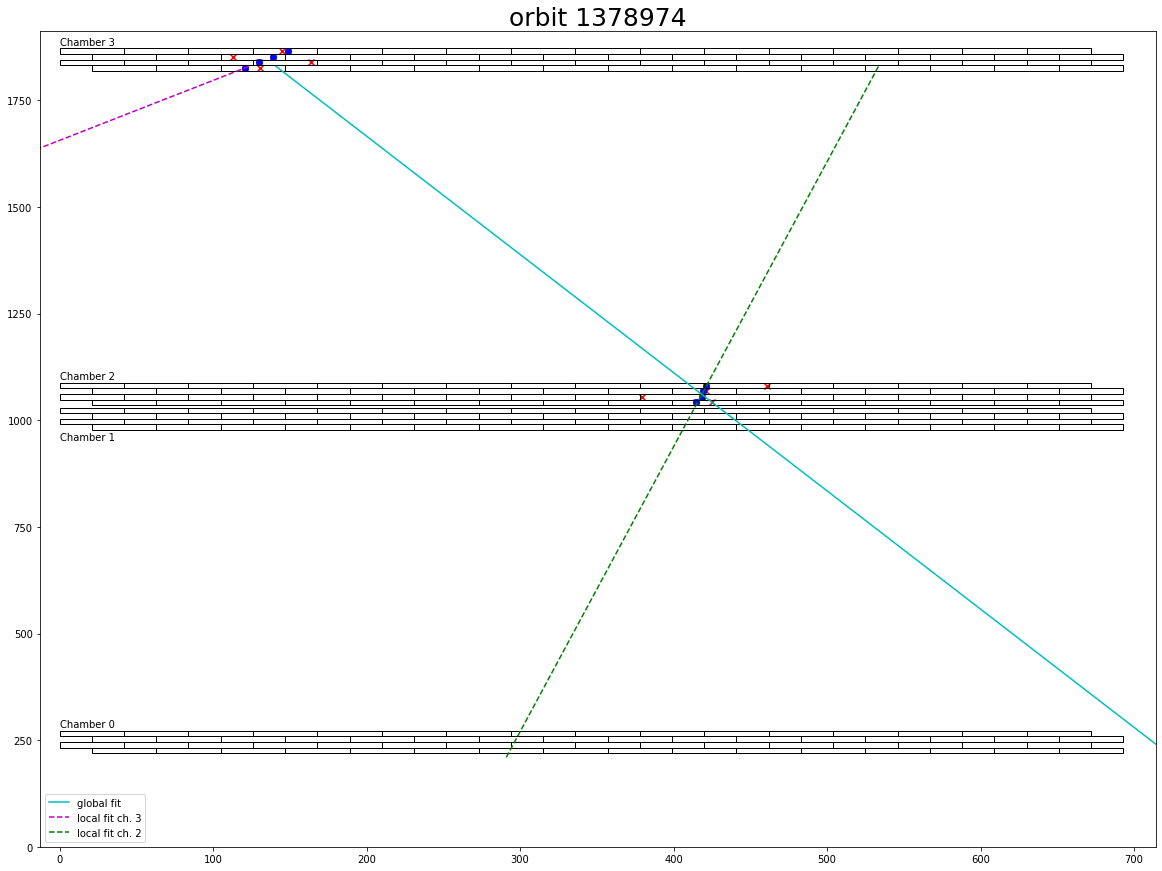

In [53]:
plot_global_fit(tmp);

We notice this event is quite peculiar, since the two local fit tracks are very differen from the global ones. Maybe this is one of the events where two distinct particles crossed the detector almost at the same time, or maybe it's an event where the noise formed an unusually tidy pattern; in any case it's an event which doesn't seem to be associated with a cleanly reconstructible trajectory, hence it's one we would like to potentially filter out of the dataset - hence adding one last filter.        
How could one filter events of this kind? Maybe by asking that events with unusually large residuals or angle differences be dropped; let's see what these quantities equal to in the case of this event.

In [54]:
print('max. residuals (abs. value):', tmp['residuals'].abs().max()) # there's no point in computing the average residuals since their sum (hence their average) is mathematically guaranteed to be zero
print('diff. angles:', diff_angles[1378974]) # this is a pandas series

max. residuals (abs. value): 21.150961404871623
diff. angles: -28.345115768998852


We obtained two important results:           
1) The filters we employed are enough to guarantee very low residuals even for the surviving noisy events, hence there's no point in filtering by max. residual.           
2) Noisy events of this kind are characterized by having very large angle differences wrt most events; this is indeed the characteristic that made this orbit visually stand out from the others.          
The above point means that *in order to remove these last noisy events one would need to drop events with $\alpha_g - \alpha_2$* larger than a given constant - but this would make our detector resolution estimate *completely* arbitrary! Before too in was not possible to uncouple it from our pipeline, but a fiter of this kind would go a step further and completely prevent us from observing large angle differences *even in principle, even with different pipelines*.        
This is the reason why this last filter was not implemented (i.e. as not to completely invalidate a somewhat sensible, but stil imperfect estimate); if one was only interested in obtaining the cleanest possible events with no need for resolution estimates, though, a filter of this kind would be relatively reasonable - and at any case it allows us to remark why the resolution estimate computed above cannot be trusted completely.

# 3D Global Fit
Let's now recover the extra information given to us by chamber 1, which is rotated 90° wrt the others. This means that a local fit performed with hits in chamber 1 yields the best fit line in the $yz$ plane (as opposed to the $xz$ plane); this lets us reconstruct the complete 3D trajectory of the particle as follows.              
Imagine that the particle trajectory satisfies the equation
\begin{equation}
  z = m_x x + q_x
\end{equation}
on the $xz$ plane and 
\begin{equation}
  z = m_y y + q_y
\end{equation}
on the $yz$ plane. These equation in 3D describe two planes; since the 3D particle trajectory needs to satisfy these two equations at the same time it means that the line we're looking for is simply *the intersection of these two planes*. We can easily turn the cartesian representation

\begin{equation}
  \left\{
    \begin{array}{c}
      \ m_x x - z + q_x = 0 \\
      \ m_y y - z + q_y = 0 \\
    \end{array}
  \right.
\end{equation}
of this line into its parametric representation:
\begin{equation}
  \left\{
  \begin{array}{c}
    \ x = -\frac{q_x}{m_x} + \frac{1}{m_x}t \\
    \ y = -\frac{q_y}{m_y} + \frac{1}{m_y}t \\
    \ z = t
  \end{array}
  \right.
\end{equation}
Notice that $(m_x, q_x)$ and $(m_y, q_y)$ in the equation above are the parameters associated with the 2D lines we plotted above, which were a *transformed* version of those returned by the `fit` function; if $m', q'$ are the parameters returned by the `fit` function then the above equations greatly simplify:
\begin{equation}
  \left\{
  \begin{array}{c}
    \ x = q_x' + m_x' t \\
    \ y = q_y' + m_y' t \\
    \ z = t
  \end{array}
  \right.
\end{equation}

This means that we only need to perform two fits (one for chamber 1, the other for chambers 0 to 3) and then use the above equation to plot the 3D trajectory.              
Before doing that we of course only pick the events where chamber 1 and at least two other chambers where active; otherwise we would miss information about the $yz$ and/or a global fit in the $xz$ plane would not be possible.

In [55]:
df3d = df12.copy()

# we ensure we have chamber 1 and at least other 2
def event3d(group) : 
    if 1 in group['chamber'].unique() and group['chamber'].nunique() > 2 : # 2nd condition ex.: we need chambers 0-1 for yz and 0-2 for xz = chamber 1 + at least other 2 = at least 3 active chambers in total
        return group 
    else :
        return None

df3d = df3d.groupby('orbit').apply(event3d, meta = slim_dtypes).reset_index(drop = True).dropna().astype(slim_dtypes)

In [56]:
def plot_3d_event(event) :
    vx = event[event.chamber != 1].xb.to_numpy()
    vzx = event[event.chamber != 1].z.to_numpy()

    vy = event[event.chamber == 1].xb.to_numpy()
    vzy = event[event.chamber == 1].z.to_numpy()

    m1, q1 = fit(vzx, vx)
    m2, q2 = fit(vzy, vy)

    t = np.linspace(170, 2000) # z is always between ~200 and ~18400; we use this bounds + something extra in both directions
    X = q1 + m1*t
    Y = q2 + m2*t
    Z = t 
    fig = px.line_3d(x = X, y = Y, z = Z) # we create a plotly.graph_objs figure through a single/simple plotly.express call, which we then update below

    l = 42*16.5
    X_s = [0, l, l, 0]*2
    Y_s = [0, 0, l, l]*2 # we assume all chambers are identical squares
    Z_s = np.array([0]*4 + [13*4]*4)
    for i in range(4) : # 4 chambers
        fig.add_mesh3d( 
            x = X_s, y = Y_s, z = Z_s + z_offset[i],
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2], 
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            opacity = 0.25,
            color = '#DC143C',
            flatshading = True # https://stackoverflow.com/questions/60371624/drawing-a-3d-box-in-a-3d-scatterplot-using-plotly
        )

    return fig

first_orbits_3d = df3d['orbit'].unique().head()
for orbit in first_orbits_3d :
    plot_3d_event(df3d[df3d.orbit == orbit].compute()).show()

Notice that since we only have one chamber capable of measuring hits in $yz$ we cannot create a 2D global fit in that plane, which means we cannot reproduce all the quantitative analysis made above for the $xz$ plane. As a consequence of this the obtained 3D trajectories cannot really be analyzed; this could be fixed e.g. by rotating by 90° chamber 3 and repeating the experiment, so that we can perform analogous local vs global 2d fits comparisons for both planes - and therefore gain more info. on the corresponding 3D trajectories. 

# An experimental verification of $n_{\text{max}} = 16$? Again
To conclude this analysis we plot the distribution of the number of hits per orbit in the filtered dataset.

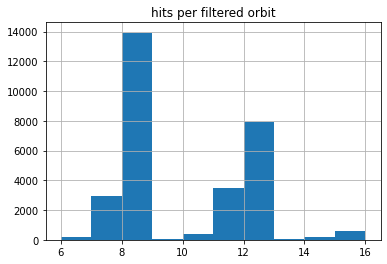

In [57]:
df12.groupby('orbit').size().compute().hist()
plt.title('hits per filtered orbit');

Notice that every $n$ is smaller than 16, which *seems* to confirm our original point (4 hits per 4 chambers); an almost identical histogram is obtained if one removes $n_{\text{max}}$ from the beginning of the notebook. As mentioned at the beginning, though, this only means that within the limits of our approach (biased towards almost vertical trajectories) everything is consistent - which is still an interesting result, definitely worth a remark.

In [59]:
#client.close()